### Question 1: Less Features is More
Find the CAGR for the pred9_clf_second_best_rule_92 using the new setup (with fewer dummy variables).

The idea: Reducing the number of features can help models perform better. As seen in the lecture, some models (e.g., Logistic Regression, Deep Neural Networks) may underperform due to too many features—especially the numerous dummy variables from exercises and individual stock tickers.

Redefine the "CATEGORICAL" set. Remove ticker and month_wom from the CATEGORICAL list just before you generate dummies ising the pd.get_dummies() function. To check yourself: df_with_dummies[NUMERICAL+DUMMIES].info() in the original setup should give 301 features. In the new setup, df_with_dummies[NUMERICAL+DUMMIES].info() should show 208 features (about 31% fewer).

Run the entire notebook. At the end of the notebook (after the bubble chart), check the CAGR for pred9_clf_second_best_rule_92 (the best predictor so far). Expected result: The new CAGR should be slightly higher than the original one, which was 1.155577.

# Imports and Installs

In [187]:
# IMPORTS
import numpy as np
import pandas as pd

#Fin Data Sources
import yfinance as yf
# import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px

import time
from datetime import date

# for graphs
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Imports form ML (Decision Trees)
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

# 0) One DataFrame with Dummies
* including newly defined "month-week_of_month"

## 0.1) Read and truncate data (last 25 years from 2000), define variable sets




In [3]:
# https://stackoverflow.com/questions/62759748/downloading-data-from-a-shared-google-drive-link-in-google-colab
# truncated data from Module 2: https://drive.google.com/file/d/1m3Qisfs2XfWk6Sw_Uk5kHLWqwQ0q8SKb/view?usp=sharing
# !gdown https://drive.google.com/file/d/1mb0ae2M5AouSDlqcUnIwaHq7avwGNrmB/view?usp=sharing --fuzzy -O /content/

In [4]:
# truncated
# df = pd.read_parquet("/content/stocks_df_combined_trunc_2014_2023.parquet.brotli", )

# full dataset for 33 stocks
df_full = pd.read_parquet("./stocks_df_combined_2025_06_13.parquet.brotli", )

In [5]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230262 entries, 0 to 5700
Columns: 203 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns](3), float64(129), int32(64), int64(5), object(2)
memory usage: 302.2+ MB


In [6]:
# growth indicators (but not future growth)
GROWTH = [g for g in df_full.keys() if (g.find('growth_')==0)&(g.find('future')<0)]
GROWTH

['growth_1d',
 'growth_3d',
 'growth_7d',
 'growth_30d',
 'growth_90d',
 'growth_365d',
 'growth_dax_1d',
 'growth_dax_3d',
 'growth_dax_7d',
 'growth_dax_30d',
 'growth_dax_90d',
 'growth_dax_365d',
 'growth_snp500_1d',
 'growth_snp500_3d',
 'growth_snp500_7d',
 'growth_snp500_30d',
 'growth_snp500_90d',
 'growth_snp500_365d',
 'growth_dji_1d',
 'growth_dji_3d',
 'growth_dji_7d',
 'growth_dji_30d',
 'growth_dji_90d',
 'growth_dji_365d',
 'growth_epi_1d',
 'growth_epi_3d',
 'growth_epi_7d',
 'growth_epi_30d',
 'growth_epi_90d',
 'growth_epi_365d',
 'growth_gold_1d',
 'growth_gold_3d',
 'growth_gold_7d',
 'growth_gold_30d',
 'growth_gold_90d',
 'growth_gold_365d',
 'growth_wti_oil_1d',
 'growth_wti_oil_3d',
 'growth_wti_oil_7d',
 'growth_wti_oil_30d',
 'growth_wti_oil_90d',
 'growth_wti_oil_365d',
 'growth_brent_oil_1d',
 'growth_brent_oil_3d',
 'growth_brent_oil_7d',
 'growth_brent_oil_30d',
 'growth_brent_oil_90d',
 'growth_brent_oil_365d',
 'growth_btc_usd_1d',
 'growth_btc_usd_3d',


In [7]:
df_full.keys()

Index(['Open', 'High', 'Low', 'Close_x', 'Volume', 'Dividends', 'Stock Splits',
       'Ticker', 'Year', 'Month',
       ...
       'growth_brent_oil_7d', 'growth_brent_oil_30d', 'growth_brent_oil_90d',
       'growth_brent_oil_365d', 'growth_btc_usd_1d', 'growth_btc_usd_3d',
       'growth_btc_usd_7d', 'growth_btc_usd_30d', 'growth_btc_usd_90d',
       'growth_btc_usd_365d'],
      dtype='object', length=203)

In [8]:
# leaving only Volume ==> generate ln(Volume)
OHLCV = ['Open','High','Low','Close_x','Volume']

In [9]:
CATEGORICAL = ['Month', 'Weekday', 'ticker_type'] # 'Ticker',

In [10]:
TO_PREDICT = [g for g in df_full.keys() if (g.find('future')>=0)]
TO_PREDICT

['growth_future_30d', 'is_positive_growth_30d_future']

In [11]:
# we define dummy variables on Dividends and Stock Splits events later, but drop the original abs. values
TO_DROP = ['Year','Date','index_x', 'index_y', 'index', 'Quarter','Close_y','Dividends','Stock Splits'] + CATEGORICAL + OHLCV
TO_DROP

['Year',
 'Date',
 'index_x',
 'index_y',
 'index',
 'Quarter',
 'Close_y',
 'Dividends',
 'Stock Splits',
 'Month',
 'Weekday',
 'ticker_type',
 'Open',
 'High',
 'Low',
 'Close_x',
 'Volume']

In [12]:
# let's define on more custom numerical features
# Add a small constant to avoid log(0)
df_full['ln_volume'] = df_full.Volume.apply(lambda x: np.log(x+ 1e-6))

In [13]:
# define columns on Dividends or Stock Splits
df_full['div_payout'] = (df_full.Dividends>0).astype(int)
df_full['stock_split'] = (df_full['Stock Splits']>0).astype(int)

In [14]:
# manually defined features
CUSTOM_NUMERICAL = ['SMA10', 'SMA20', 'growing_moving_average', 'high_minus_low_relative','volatility', 
                    'ln_volume','div_payout','stock_split']

In [15]:
# All Supported Ta-lib indicators: https://github.com/TA-Lib/ta-lib-python/blob/master/docs/funcs.md

TECHNICAL_INDICATORS = ['adx', 'adxr', 'apo', 'aroon_1','aroon_2', 'aroonosc',
 'bop', 'cci', 'cmo','dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext',
 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix',
 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo',
 'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk',
 'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr',
 'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase',
 'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine',
 'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice']

In [16]:
TECHNICAL_PATTERNS = [g for g in df_full.keys() if g.find('cdl')>=0]
print(f'Technical patterns count = {len(TECHNICAL_PATTERNS)}, examples = {TECHNICAL_PATTERNS[0:5]}')

Technical patterns count = 61, examples = ['cdl2crows', 'cdl3blackrows', 'cdl3inside', 'cdl3linestrike', 'cdl3outside']


In [17]:
MACRO = ['gdppot_us_yoy', 'gdppot_us_qoq', 'cpi_core_yoy', 'cpi_core_mom', 'FEDFUNDS',
 'DGS1', 'DGS5', 'DGS10']

In [18]:
NUMERICAL = GROWTH + TECHNICAL_INDICATORS + TECHNICAL_PATTERNS + CUSTOM_NUMERICAL + MACRO

In [19]:
# CHECK: NO OTHER INDICATORS LEFT
OTHER = [k for k in df_full.keys() if k not in OHLCV + CATEGORICAL + NUMERICAL + TO_DROP + TO_PREDICT]
OTHER

['Ticker']

In [20]:
df_full.Ticker.nunique()

33

In [21]:
# truncated df_full with 25 years of data (and defined growth variables)
df = df_full[df_full.Date>='2000-01-01']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 206 entries, Open to stock_split
dtypes: datetime64[ns](3), float64(130), int32(64), int64(7), object(2)
memory usage: 256.1+ MB


In [22]:
# tickers, min-max date, count of daily observations
df.groupby(['Ticker'])['Date'].agg(['min','max','count'])

,min,max,count
Ticker,,,
AAPL,2000-01-03,2025-06-13,6401
ACN,2001-07-19,2025-06-13,6012
AMZN,2000-01-03,2025-06-13,6401
ASML,2000-01-03,2025-06-13,6401
AVGO,2009-08-06,2025-06-13,3989
BHARTIARTL.NS,2002-07-01,2025-06-13,5698
BRK-B,2000-01-03,2025-06-13,6401
CDI.PA,2000-01-03,2025-06-13,6540
GOOG,2004-08-19,2025-06-13,5239


## 0.2) Dummies

In [23]:
# what are the categorical features?
CATEGORICAL

['Month', 'Weekday', 'ticker_type']

In [24]:
# dummy variables are not generated from Date and numeric variables

# df.loc[:,'Month'] = df['Month'].dt.strftime('%B').astype('string')

df.loc[:,'Month']= pd.to_datetime(df['Month'], format='%m').dt.strftime('%B')

df.loc[:,'Weekday'] = df['Weekday'].astype('string')
# .astype(str)

/var/folders/rj/25gyk3bn7_g60b0fxzrg3jn40000gq/T/ipykernel_12525/2619569166.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['January' 'January' 'January' ... 'June' 'June' 'June']' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df.loc[:,'Month']= pd.to_datetime(df['Month'], format='%m').dt.strftime('%B')
/var/folders/rj/25gyk3bn7_g60b0fxzrg3jn40000gq/T/ipykernel_12525/2619569166.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<StringArray>
['0', '1', '2', '3', '4', '0', '1', '2', '3', '4',
 ...
 '0', '1', '2', '3', '4', '0', '1', '2', '3', '4']
Length: 191795, dtype: string' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df.loc[:,'Weekday'] = df['Weekday'].astype('string')


### 0.2.1) Create a new string column 'month_wom' (month_week_of_month)

In [25]:
# define week of month
df.loc[:,'wom'] = df.Date.apply(lambda d: (d.day-1)//7 + 1)
# convert to string
df.loc[:,'wom'] = df.loc[:,'wom'].astype(str)

/var/folders/rj/25gyk3bn7_g60b0fxzrg3jn40000gq/T/ipykernel_12525/1081537706.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1' '1' '1' ... '2' '2' '2']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:,'wom'] = df.loc[:,'wom'].astype(str)


In [26]:
# check values for week-of-month (should be between 1 and 5)
df.wom.value_counts()

wom
2    45083
3    44006
4    43753
1    43557
5    15396
Name: count, dtype: int64

In [27]:
df.loc[:,'month_wom'] = df.Month + '_w' + df.wom

In [28]:
# examples of encoding
df.month_wom.value_counts()[0:2]

month_wom
June_w1        3882
February_w1    3878
Name: count, dtype: int64

In [29]:
# del wom temp variable
del df['wom']

### 0.2.2) Generate all dummies

In [30]:
# what are the categorical features?
# CATEGORICAL.append('month_wom')
CATEGORICAL

['Month', 'Weekday', 'ticker_type']

In [31]:
# Generate dummy variables (no need for bool, let's have int32 instead)
dummy_variables = pd.get_dummies(df[CATEGORICAL], dtype='int32')

In [32]:
dummy_variables.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Month_April        191795 non-null  int32
 1   Month_August       191795 non-null  int32
 2   Month_December     191795 non-null  int32
 3   Month_February     191795 non-null  int32
 4   Month_January      191795 non-null  int32
 5   Month_July         191795 non-null  int32
 6   Month_June         191795 non-null  int32
 7   Month_March        191795 non-null  int32
 8   Month_May          191795 non-null  int32
 9   Month_November     191795 non-null  int32
 10  Month_October      191795 non-null  int32
 11  Month_September    191795 non-null  int32
 12  Weekday_0          191795 non-null  int32
 13  Weekday_1          191795 non-null  int32
 14  Weekday_2          191795 non-null  int32
 15  Weekday_3          191795 non-null  int32
 16  Weekday_4          191795 non-null  int32


In [33]:
# get dummies names in a list
DUMMIES = dummy_variables.keys().to_list()
DUMMIES

['Month_April',
 'Month_August',
 'Month_December',
 'Month_February',
 'Month_January',
 'Month_July',
 'Month_June',
 'Month_March',
 'Month_May',
 'Month_November',
 'Month_October',
 'Month_September',
 'Weekday_0',
 'Weekday_1',
 'Weekday_2',
 'Weekday_3',
 'Weekday_4',
 'Weekday_5',
 'Weekday_6',
 'ticker_type_EU',
 'ticker_type_INDIA',
 'ticker_type_US']

In [34]:
len(DUMMIES)

22

In [35]:
# Concatenate the dummy variables with the original DataFrame
df_with_dummies = pd.concat([df, dummy_variables], axis=1)

In [36]:
df_with_dummies[NUMERICAL+DUMMIES].info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 208 entries, growth_1d to ticker_type_US
dtypes: float64(121), int32(84), int64(3)
memory usage: 244.4 MB


### 1.2.3) Get correlations for month_wom (month-week_of_month) with is_futur

In [37]:
DUMMIES_MONTH_WOM = [k for k in DUMMIES if k.startswith('month_wom')]
# check a few records
DUMMIES_MONTH_WOM[0:2]

[]

In [38]:
corr_month_wom_vs_is_positive_growth_30d_future = df_with_dummies[DUMMIES_MONTH_WOM+TO_PREDICT].corr()['is_positive_growth_30d_future']

In [39]:
corr_month_wom_vs_is_positive_growth_30d_future

growth_future_30d                0.696468
is_positive_growth_30d_future    1.000000
Name: is_positive_growth_30d_future, dtype: float64

In [40]:
# create a dataframe for an easy way to sort
corr_month_wom_vs_is_positive_growth_30d_future_df = pd.DataFrame(corr_month_wom_vs_is_positive_growth_30d_future)

In [41]:
# rename column 'is_positive_growth_5d_future' to 'corr'
corr_month_wom_vs_is_positive_growth_30d_future_df.rename(columns={'is_positive_growth_30d_future':'corr'},inplace=True)

In [42]:
corr_month_wom_vs_is_positive_growth_30d_future_df.loc[:, 'abs_corr'] = corr_month_wom_vs_is_positive_growth_30d_future_df['corr'].abs()

In [43]:
corr_month_wom_vs_is_positive_growth_30d_future_df.sort_values(by='abs_corr')

,corr,abs_corr
growth_future_30d,0.696468,0.696468
is_positive_growth_30d_future,1.000000,1.000000


In [44]:
# ANSWER Q1 HA3: # TOP CORR NEW DUMMY with is_positive: ANSWER 0.025 (rounded to 3 digits)

### 1.2.4) Temporal split

In [45]:
def temporal_split(df, min_date, max_date, train_prop=0.7, val_prop=0.15, test_prop=0.15):
    """
    Splits a DataFrame into three buckets based on the temporal order of the 'Date' column.

    Args:
        df (DataFrame): The DataFrame to split.
        min_date (str or Timestamp): Minimum date in the DataFrame.
        max_date (str or Timestamp): Maximum date in the DataFrame.
        train_prop (float): Proportion of data for training set (default: 0.6).
        val_prop (float): Proportion of data for validation set (default: 0.2).
        test_prop (float): Proportion of data for test set (default: 0.2).

    Returns:
        DataFrame: The input DataFrame with a new column 'split' indicating the split for each row.
    """
    # Define the date intervals
    train_end = min_date + pd.Timedelta(days=(max_date - min_date).days * train_prop)
    val_end = train_end + pd.Timedelta(days=(max_date - min_date).days * val_prop)

    # Assign split labels based on date ranges
    split_labels = []
    for date in df['Date']:
        if date <= train_end:
            split_labels.append('train')
        elif date <= val_end:
            split_labels.append('validation')
        else:
            split_labels.append('test')

    # Add 'split' column to the DataFrame
    df['split'] = split_labels

    return df

In [46]:
min_date_df = df_with_dummies.Date.min()
max_date_df = df_with_dummies.Date.max()

df_with_dummies = temporal_split(df_with_dummies,
                                 min_date = min_date_df,
                                 max_date = max_date_df)

In [47]:
df_with_dummies['split'].value_counts()/len(df_with_dummies)

split
train         0.676399
test          0.163758
validation    0.159843
Name: count, dtype: float64

In [48]:
# remove the "segmentation" problem (warning message on df performance after many joins and data transformations)
new_df = df_with_dummies.copy()

# 1) Modeling

In [49]:
# Full dataframe (transformed and truncated to 25 years)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 230 entries, Open to split
dtypes: datetime64[ns](2), float64(130), int32(85), int64(7), object(5), string(1)
memory usage: 275.8+ MB


In [50]:
# check one record: it has abs. values, text, and numbers
new_df.head(1)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,ticker_type_EU,ticker_type_INDIA,ticker_type_US,split
3490,35.975752,36.358881,34.3283,35.726719,53228400.0,0.0,0.0,MSFT,2000,January,...,0,0,0,0,0,0,0,0,1,train


In [51]:
# time split on train/validation/test: FIXED dates of split, approx. 70%, 15%, 15% split
new_df.groupby(['split'])['Date'].agg({'min','max','count'})

,max,min,count
split,,,
test,2025-06-13,2021-08-20,31408
train,2017-10-25,2000-01-03,129730
validation,2021-08-19,2017-10-26,30657


In [52]:
# check for imbalances of growth for train/test/validation
new_df.groupby(by='split')['growth_future_30d'].describe()

,count,mean,std,min,25%,50%,75%,max
split,,,,,,,,
test,30418.0,1.019899,0.102172,0.580332,0.955986,1.016057,1.077950,1.648934
train,129730.0,1.023864,0.123190,0.246131,0.960248,1.020585,1.083310,5.179689
validation,30657.0,1.029596,0.099908,0.461847,0.973991,1.030784,1.086687,1.783610


In [53]:
# what do we try to predict
new_df[TO_PREDICT].head(1)

,growth_future_30d,is_positive_growth_30d_future
3490,0.845576,0


In [54]:
# to be used as features
new_df[NUMERICAL+DUMMIES].head(1)

,growth_1d,growth_3d,growth_7d,growth_30d,growth_90d,growth_365d,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,...,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,ticker_type_EU,ticker_type_INDIA,ticker_type_US
3490,0.998394,0.988341,0.991494,1.372333,1.22295,2.063054,0.970196,0.983855,1.051736,1.134572,...,1,0,0,0,0,0,0,0,0,1


## 1.1) Manual 'rule of thumb' predictions
* (pred0) CCI>200 (binary, on technical indicator CCI)
* (pred1) growth_30d>1
* (pred2) (growth_30d>1) & (growth_snp500_30d>1)
* (pred3) (DGS10 <= 4) & (DGS5 <= 1)
* (pred4) (DGS10 > 4) & (FEDFUNDS <= 4.795)

In [55]:
# generate manual predictions
# Let's label all prediction features with prefix "pred"
new_df['pred0_manual_cci'] = (new_df.cci>200).astype(int)
new_df['pred1_manual_prev_g1'] = (new_df.growth_30d>1).astype(int)
new_df['pred2_manual_prev_g1_and_snp'] = ((new_df['growth_30d'] > 1) & (new_df['growth_snp500_30d'] > 1)).astype(int)

In [56]:
# new manual predictions from HA
new_df['pred3_manual_dgs10_5'] = ((new_df['DGS10'] <= 4) & (new_df['DGS5'] <= 1)).astype(int)
new_df['pred4_manual_dgs10_fedfunds'] = ((new_df['DGS10'] > 4) & (new_df['FEDFUNDS'] <= 4.795)).astype(int)

In [57]:
# sample of 10 observations and predictions
new_df[['cci','growth_30d','growth_snp500_30d','pred0_manual_cci','pred1_manual_prev_g1','pred2_manual_prev_g1_and_snp','pred3_manual_dgs10_5','pred4_manual_dgs10_fedfunds','is_positive_growth_30d_future']].sample(10)

,cci,growth_30d,growth_snp500_30d,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_dgs10_5,pred4_manual_dgs10_fedfunds,is_positive_growth_30d_future
9809,-203.701229,1.064851,1.097329,0,1,1,0,0,0
3299,198.606497,1.088514,1.071930,0,1,1,0,1,0
4889,122.957644,1.073889,1.060845,0,1,1,0,0,0
490,178.823670,1.318102,1.079960,0,1,1,0,0,1
3991,54.089828,1.002961,0.884831,0,1,0,1,0,0
9098,310.663761,1.051478,1.052604,1,1,1,0,0,1
2942,-165.048723,0.969121,1.039297,0,0,0,0,0,1
9577,-32.692962,0.803565,0.979745,0,0,0,0,0,0
5698,208.314467,0.982031,0.989130,1,0,0,0,0,1
4432,75.056889,1.039366,1.033102,0,1,1,0,0,1


In [58]:
# List of current predictions
PREDICTIONS = [k for k in new_df.keys() if k.startswith('pred')]
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_dgs10_5',
 'pred4_manual_dgs10_fedfunds']

In [59]:
# Function to find all predictions (starting from 'pred'), generate is_correct (correctness of each prediction)
# and precision on TEST dataset (assuming there is df["split"] column with values 'train','validation','test'

# returns 2 lists of features: PREDICTIONS and IS_CORRECT

def get_predictions_correctness(df:pd.DataFrame, to_predict:str):
  PREDICTIONS = [k for k in df.keys() if k.startswith('pred')]
  print(f'Prediction columns founded: {PREDICTIONS}')

  # add columns is_correct_
  for pred in PREDICTIONS:
    part1 = pred.split('_')[0] # first prefix before '_'
    df[f'is_correct_{part1}'] =  (new_df[pred] == new_df[to_predict]).astype(int)

  # IS_CORRECT features set
  IS_CORRECT =  [k for k in df.keys() if k.startswith('is_correct_')]
  print(f'Created columns is_correct: {IS_CORRECT}')

  print('Precision on TEST set for each prediction:')
  # define "Precision" for ALL predictions on a Test dataset (~4 last years of trading)
  for i,column in enumerate(IS_CORRECT):
    prediction_column = PREDICTIONS[i]
    is_correct_column = column
    filter = (new_df.split=='test') & (new_df[prediction_column]==1)
    print(f'Prediction column:{prediction_column} , is_correct_column: {is_correct_column}')
    print(new_df[filter][is_correct_column].value_counts())
    print(new_df[filter][is_correct_column].value_counts()/len(new_df[filter]))
    print('---------')

  return PREDICTIONS, IS_CORRECT

In [60]:
PREDICTIONS, IS_CORRECT = get_predictions_correctness(new_df, to_predict='is_positive_growth_30d_future')

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_dgs10_5', 'pred4_manual_dgs10_fedfunds']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    443
0    351
Name: count, dtype: int64
is_correct_pred0
1    0.557935
0    0.442065
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    9748
0    8243
Name: count, dtype: int64
is_correct_pred1
1    0.541826
0    0.458174
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
1    6984
0    6383
Name: count, dtype: int64
is_correct_pred2
1    0.522481
0    0.477519
Name: count, dtype: float64
-------

In [61]:
# sample of 10 predictions vs. is_correct vs. is_positive_growth_30d_future (what we're trying to predict)
new_df[PREDICTIONS+IS_CORRECT+['is_positive_growth_30d_future']].sample(10)

,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_dgs10_5,pred4_manual_dgs10_fedfunds,is_correct_pred0,is_correct_pred1,is_correct_pred2,is_correct_pred3,is_correct_pred4,is_positive_growth_30d_future
470,0,0,0,0,1,0,0,0,0,1,1
552,0,0,0,0,1,0,0,0,0,1,1
4641,0,1,1,0,0,1,0,0,1,1,0
4732,0,1,1,0,0,1,0,0,1,1,0
4995,0,0,0,1,0,1,1,1,0,1,0
3229,0,1,1,0,0,0,1,1,0,0,1
1557,0,1,1,0,1,0,1,1,0,1,1
5342,0,1,1,0,0,1,0,0,1,1,0
6514,0,1,1,0,1,0,1,1,0,1,1
7318,0,1,1,0,1,1,0,0,1,0,0


In [62]:
len(new_df[new_df.split=='test'])

31408

In [63]:
# ANSWER Q2: best is pred3_manual_dgs10_5 with precision = 0.580 (rounded)

In [64]:
# pred4 seems to be empty on Test - let's check why?

# it used to be some stats
new_df[(new_df['gdppot_us_yoy'] >= 0.027) & (new_df['growth_wti_oil_30d'] <= 1.005)]

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_dgs10_5,pred4_manual_dgs10_fedfunds,is_correct_pred0,is_correct_pred1,is_correct_pred2,is_correct_pred3,is_correct_pred4
3682,17.010899,17.547278,16.934273,16.972586,81099400.0,0.0,0.0,MSFT,2000,October,...,0,0,0,0,0,0,0,0,0,0
3683,17.106682,17.394028,16.781023,17.030056,61794000.0,0.0,0.0,MSFT,2000,October,...,0,0,0,0,0,0,0,0,0,0
3684,17.049210,17.087522,16.244640,16.608612,58323600.0,0.0,0.0,MSFT,2000,October,...,0,0,0,0,0,0,0,0,0,0
3689,16.397884,16.493666,15.191030,15.440063,119759000.0,0.0,0.0,MSFT,2000,October,...,0,0,0,0,0,0,0,0,0,0
3690,15.899824,16.072232,15.401757,15.459227,81276600.0,0.0,0.0,MSFT,2000,October,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1690,115.265769,115.265769,112.248964,112.965836,1009151.0,0.0,0.0,HINDUNILVR.NS,2002,June,...,0,0,0,0,1,1,1,1,1,0
1691,113.503511,115.773583,113.115213,113.981422,1117609.0,0.0,0.0,HINDUNILVR.NS,2002,June,...,0,0,0,0,1,1,1,1,1,0
1692,118.879979,118.879979,113.951538,114.847618,703080.0,0.0,0.0,HINDUNILVR.NS,2002,June,...,0,0,0,0,1,1,1,1,1,0
1693,115.893030,116.191724,113.145047,113.443741,1403644.0,0.0,0.0,HINDUNILVR.NS,2002,June,...,0,0,0,0,1,1,1,1,1,0


## 1.2) Decision Tree Classifier

### 1.2.1) Defining Functions to clean_df(), fit_decision_tree(), predict_decision_tree()
* here we utilize only Decision Tree Classifier (and not Regressor)

In [65]:
# Prepare a dataframe for ML:
  # +-inf to NaN, all NaNs to 0s
def clean_dataframe_from_inf_and_nan(df:pd.DataFrame):
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
  df.fillna(0, inplace=True)
  return df

In [66]:
# Estimation/fit function (using dataframe of features X and what to predict y) --> optimising total accuracy
# max_depth is hyperParameter
def fit_decision_tree(X, y, max_depth=20):
# Initialize the Decision Tree Classifier
  clf = DecisionTreeClassifier(max_depth=max_depth,
                               random_state=42)

  # Fit the classifier to the training data
  clf.fit(X, y)
  return clf, X.columns

### 1.2.2) CLF10 (Decision Tree Classifier, max_depth==10): get unique correct predictions vs. pred0_manual...pred4_manual
* Fit(Train) on TRAIN+VALIDATION
* Predict on ALL and Join to the original new_df
* Get Precision on TEST

In [67]:
# Features to be used in predictions (incl. new dummies)
features_list = NUMERICAL+DUMMIES
# What we're trying to predict?
to_predict = 'is_positive_growth_30d_future'

train_valid_df = new_df[new_df.split.isin(['train','validation'])].copy(deep=True)
test_df = new_df[new_df.split.isin(['test'])].copy(deep=True)

# ONLY numerical Separate features and target variable for training and testing sets
X_train_valid = train_valid_df[features_list+[to_predict]]
X_test = test_df[features_list+[to_predict]]

# this to be used for predictions and join to the original dataframe new_df
X_all =  new_df[features_list+[to_predict]].copy(deep=True)

print(f'length: X_train_valid {X_train_valid.shape},  X_test {X_test.shape}, all combined: X_all {X_all.shape}')


length: X_train_valid (160387, 209),  X_test (31408, 209), all combined: X_all (191795, 209)


In [68]:
# Clean from +-inf and NaNs:

X_train_valid = clean_dataframe_from_inf_and_nan(X_train_valid)
# X_test = clean_dataframe_from_inf_and_nan(X_test) # won't use
X_all = clean_dataframe_from_inf_and_nan(X_all)

In [69]:
y_train_valid = X_train_valid[to_predict]
# y_test = X_test[to_predict] # won't use
y_all =  X_all[to_predict]

# remove y_train, y_test from X_ dataframes
del X_train_valid[to_predict]
del X_test[to_predict]
del X_all[to_predict]

In [70]:
%%time
clf_10, train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=10)

CPU times: user 13.1 s, sys: 77.9 ms, total: 13.2 s
Wall time: 13.2 s


In [71]:
X_train_valid.shape

(160387, 208)

In [72]:
X_all.shape

(191795, 208)

In [73]:
y_all.shape

(191795,)

In [74]:
# predict on a full dataset
y_pred_all = clf_10.predict(X_all)

In [75]:
# defining a new prediction vector is easy now, as the dimensions will match
new_df['pred5_clf_10'] = y_pred_all

In [76]:
# new prediction is added --> need to recalculate the correctness
PREDICTIONS, IS_CORRECT = get_predictions_correctness(new_df, to_predict='is_positive_growth_30d_future')

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_dgs10_5', 'pred4_manual_dgs10_fedfunds', 'pred5_clf_10']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    443
0    351
Name: count, dtype: int64
is_correct_pred0
1    0.557935
0    0.442065
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    9748
0    8243
Name: count, dtype: int64
is_correct_pred1
1    0.541826
0    0.458174
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
1    6984
0    6383
Name: count, dtype: int64
is_correct_pred2
1    0.522481
0    0.477519

In [77]:
IS_CORRECT

['is_correct_pred0',
 'is_correct_pred1',
 'is_correct_pred2',
 'is_correct_pred3',
 'is_correct_pred4',
 'is_correct_pred5']

In [78]:
# define a new column that find the cases when only pred5 is correct
new_df['only_pred5_is_correct'] = (new_df.is_correct_pred5==new_df.is_positive_growth_30d_future) & \
                         (new_df.is_positive_growth_30d_future == 1) & \
                         (new_df.is_correct_pred0 == 0) & \
                         (new_df.is_correct_pred1 == 0) & \
                         (new_df.is_correct_pred2 == 0) & \
                         (new_df.is_correct_pred3 == 0) & \
                         (new_df.is_correct_pred4 == 0)

In [79]:
# need it to be integer and not bool
new_df['only_pred5_is_correct'] = new_df['only_pred5_is_correct'].astype(int)

In [80]:
# how many times only pred5 is correct in the TEST set?
new_df[new_df.split=='test']['only_pred5_is_correct'].sum()

np.int64(3601)

In [81]:
# let's look at the record
filter_unique_pred_5 = (new_df.split=='test') & (new_df.only_pred5_is_correct==1)

In [82]:
# sample with only Pred5 correct
new_df[filter_unique_pred_5].sample(10)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,pred3_manual_dgs10_5,pred4_manual_dgs10_fedfunds,is_correct_pred0,is_correct_pred1,is_correct_pred2,is_correct_pred3,is_correct_pred4,pred5_clf_10,is_correct_pred5,only_pred5_is_correct
10841,125.304269,127.588769,125.010124,126.686737,5184400.0,0.0,0.0,NVO,2024,May,...,0,0,0,0,0,0,0,1,1,1
9529,366.509642,368.912360,363.048926,363.810272,20901500.0,0.0,0.0,MSFT,2024,January,...,0,0,0,0,0,0,0,1,1,1
10892,130.247100,131.123029,129.504464,130.875488,7399900.0,0.0,0.0,JPM,2023,May,...,0,0,0,0,0,0,0,1,1,1
6499,93.830002,95.070000,92.709999,94.879997,60912700.0,0.0,0.0,AMZN,2023,March,...,0,0,0,0,0,0,0,1,1,1
6936,404.267546,417.987242,404.218733,405.585815,1084700.0,0.0,0.0,ASML,2022,September,...,0,0,0,0,0,0,0,1,1,1
4116,253.745398,259.314926,253.745398,257.587463,7062200.0,0.0,0.0,V,2024,July,...,0,0,0,0,0,0,0,1,1,1
7923,591.660251,599.197325,583.652111,586.007446,2163.0,0.0,0.0,CDI.PA,2022,October,...,0,0,0,0,0,0,0,1,1,1
6860,177.919998,179.009995,177.429993,178.880005,26255200.0,0.0,0.0,AMZN,2024,August,...,0,0,0,0,0,0,0,1,1,1
5979,17.450851,17.488604,17.328158,17.375347,6741000.0,0.0,0.0,INFY,2022,December,...,0,0,0,0,0,0,0,1,1,1
12983,595.024502,597.518761,585.097066,585.483093,2630700.0,0.0,0.0,LLY,2023,November,...,0,0,0,0,0,0,0,1,1,1


In [83]:
# let's visually check that all predictions are 0, but pred5==1 (sample 10)
new_df[filter_unique_pred_5][PREDICTIONS+IS_CORRECT+['is_positive_growth_30d_future']].sample(10)

,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_dgs10_5,pred4_manual_dgs10_fedfunds,pred5_clf_10,is_correct_pred0,is_correct_pred1,is_correct_pred2,is_correct_pred3,is_correct_pred4,is_correct_pred5,is_positive_growth_30d_future
6986,0,0,0,0,0,1,0,0,0,0,0,1,1
10609,0,0,0,0,0,1,0,0,0,0,0,1,1
5182,0,0,0,0,0,1,0,0,0,0,0,1,1
6365,0,0,0,0,0,1,0,0,0,0,0,1,1
7079,0,0,0,0,0,1,0,0,0,0,0,1,1
6717,0,0,0,0,0,1,0,0,0,0,0,1,1
11111,0,0,0,0,0,1,0,0,0,0,0,1,1
3828,0,0,0,0,0,1,0,0,0,0,0,1,1
10797,0,0,0,0,0,1,0,0,0,0,0,1,1
5192,0,0,0,0,0,1,0,0,0,0,0,1,1


In [84]:
# ANSWER HA3: 3659 unique correct prediction from clf_10 (on test)

## 1.2.3 [Code Snippet 2] Hyperparams tuning for a Decision Tree Classifier

In [85]:
# TODO HA: Define DUMMIES_SHORT to include only original dummies (and exclude too detailed dummies like month_week_of_month, let's leave only month) --> less features

In [86]:
# Features to be used in predictions (incl. new dummies)
features_list = NUMERICAL+DUMMIES
# What we're trying to predict?
to_predict = 'is_positive_growth_30d_future'

train_df = new_df[new_df.split.isin(['train'])].copy(deep=True)
valid_df = new_df[new_df.split.isin(['validation'])].copy(deep=True)
train_valid_df = new_df[new_df.split.isin(['train','validation'])].copy(deep=True)

test_df =  new_df[new_df.split.isin(['test'])].copy(deep=True)

# ONLY numerical Separate features and target variable for training and testing sets
X_train = train_df[features_list+[to_predict]]
X_valid = valid_df[features_list+[to_predict]]

X_train_valid = train_valid_df[features_list+[to_predict]]

X_test = test_df[features_list+[to_predict]]

# this to be used for predictions and join to the original dataframe new_df
X_all =  new_df[features_list+[to_predict]].copy(deep=True)

print(f'length: X_train {X_train.shape},  X_validation {X_valid.shape}, X_test {X_test.shape}, X_train_valid = {X_train_valid.shape},  all combined: X_all {X_all.shape}')

length: X_train (129730, 209),  X_validation (30657, 209), X_test (31408, 209), X_train_valid = (160387, 209),  all combined: X_all (191795, 209)


In [87]:
# Clean from +-inf and NaNs:

X_train = clean_dataframe_from_inf_and_nan(X_train)
X_valid = clean_dataframe_from_inf_and_nan(X_valid)
X_train_valid = clean_dataframe_from_inf_and_nan(X_train_valid)

X_test = clean_dataframe_from_inf_and_nan(X_test)

X_all = clean_dataframe_from_inf_and_nan(X_all)

In [88]:
y_train = X_train[to_predict]
y_valid = X_valid[to_predict]

y_train_valid = X_train_valid[to_predict]
y_test = X_test[to_predict]
y_all =  X_all[to_predict]

# remove y_train, y_test from X_ dataframes
del X_train[to_predict]
del X_valid[to_predict]
del X_train_valid[to_predict]

del X_test[to_predict]

del X_all[to_predict]

In [89]:
# visualisation: decision tree for a few levels (max_depth variable)
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/20156951/how-do-i-find-which-attributes-my-tree-splits-on-when-using-scikit-learn
from sklearn.tree import export_text


In [90]:
# (8min runtime) UNCOMMENT TO RUN IT AGAIN
# %%time
# # hyper params tuning for a Decision Tree

# precision_by_depth = {}
# best_precision = 0
# best_depth = 0

# for depth in range(1,21):
#   print(f'Working with a tree of a max depth= {depth}')
#   # fitting the tree on X_train, y_train
#   clf,train_columns = fit_decision_tree(X=X_train_valid,
#                            y=y_train_valid,
#                            max_depth=depth) #applying custom hyperparam
#   # getting the predictions for TEST and accuracy score
#   y_pred_valid = clf.predict(X_valid)
#   precision_valid = precision_score(y_valid, y_pred_valid)
#   y_pred_test = clf.predict(X_test)
#   precision_test = precision_score(y_test, y_pred_test)
#   print(f'  Precision on test is {precision_test}, (precision on valid is {precision_valid} - tend to overfit)')
#   # saving to the dict
#   precision_by_depth[depth] = round(precision_test,4)
#   # updating the best precision
#   if precision_test >= best_precision:
#     best_precision = round(precision_test,4)
#     best_depth = depth
#   # plot tree - long
#   # plt.figure(figsize=(20,10))  # Set the size of the figure
#   # plot_tree(clf,
#   #           filled=True,
#   #           feature_names=train_columns,
#   #           class_names=['Negative', 'Positive'],
#   #           max_depth=2)
#   # plt.show()
#   # plot tree - short
#   tree_rules = export_text(clf, feature_names=list(X_train), max_depth=3)
#   print(tree_rules)
#   print('------------------------------')

# print(f'All precisions by depth: {precision_by_depth}')
# print(f'The best precision is {best_precision} and the best depth is {best_depth} ')

In [91]:
# Results of Hyper parameters tuning for a Decision Tree
# print(precision_by_depth)

In [92]:
# pre-calculated results
precision_by_depth = {1: 0.5466, 2: 0.5511, 3: 0.5511, 4: 0.5511, 5: 0.6278, 6: 0.5691, 7: 0.5945, 8: 0.5891, 9: 0.5912, 10: 0.5888, 11: 0.5916, 12: 0.5855, 13: 0.5822, 14: 0.592, 15: 0.5833, 16: 0.5898, 17: 0.586, 18: 0.5861, 19: 0.5869, 20: 0.5773}




In [93]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(precision_by_depth.items()), columns=['max_depth', 'precision_score'])
df.loc[:,'precision_score'] = df.precision_score*100.0 # need for % visualisation

# Create the bar chart using Plotly Express
fig = px.bar(df,
             x='max_depth',
             y='precision_score',
            #  title='Precision Score vs. Max Depth for a Decision Tree',
             labels={'max_depth': 'Max Depth', 'precision_score': 'Precision Score'},
             range_y=[54, 65],
             text='precision_score')

# Update the text format to display as percentages
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')

# Center the title
fig.update_layout(title={'text': 'Precision Score vs. Max Depth for a Decision Tree', 'x': 0.5, 'xanchor': 'center'})


# Show the figure
fig.show()

In [94]:
%%time
clf_5, train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=5)


# predict on a full dataset
y_pred_all = clf_5.predict(X_all)


# defining a new prediction vector is easy now, as the dimensions will match
new_df['pred6_clf_5'] = y_pred_all

CPU times: user 7.19 s, sys: 149 ms, total: 7.34 s
Wall time: 7.42 s


In [95]:
# MANUAL SECOND BEST, need some complexity
# found earlier in HyperParams Tuning
best_depth = 14
best_precision = precision_by_depth[best_depth]

In [96]:
print(f'Best precision and depth = {best_depth}, precision (on test)={best_precision}')

Best precision and depth = 14, precision (on test)=0.592


In [97]:
%%time
clf_best, train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=best_depth)

CPU times: user 17.2 s, sys: 78.1 ms, total: 17.2 s
Wall time: 17.3 s


In [98]:
# For a DecisionTreeClassifier in scikit-learn, the concept of trainable parameters differs from that of neural networks.
# In decision trees, the parameters are the structure of the tree itself (nodes and splits) rather than weights.
# However, you can still get a sense of the model's complexity by looking at the number of nodes and leaves.

# Here's how you can get this information for your trained DecisionTreeClassifier (referred to as clf_best):

# Get the number of nodes and leaves in the tree
n_nodes = clf_best.tree_.node_count
n_leaves = clf_best.get_n_leaves()

print(f"Number of nodes: {n_nodes}")
print(f"Number of leaves: {n_leaves}")

Number of nodes: 4877
Number of leaves: 2439


In [99]:
clf_best

,criterion,'gini'
,splitter,'best'
,max_depth,14
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [100]:
# predict on a full dataset
y_pred_clf_best = clf_best.predict(X_all)

In [101]:
# defining a new prediction vector is easy now, as the dimensions will match
new_df['pred7_clf_second_best'] = y_pred_clf_best

In [102]:
# new prediction is added --> need to recalculate the correctness
PREDICTIONS, IS_CORRECT = get_predictions_correctness(new_df, to_predict='is_positive_growth_30d_future')

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_dgs10_5', 'pred4_manual_dgs10_fedfunds', 'pred5_clf_10', 'pred6_clf_5', 'pred7_clf_second_best']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5', 'is_correct_pred6', 'is_correct_pred7']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    443
0    351
Name: count, dtype: int64
is_correct_pred0
1    0.557935
0    0.442065
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    9748
0    8243
Name: count, dtype: int64
is_correct_pred1
1    0.541826
0    0.458174
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
1    6984


### 1.2.4) Two ways of visualisation

In [103]:
# train a simple tree
clf_2,train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=2)

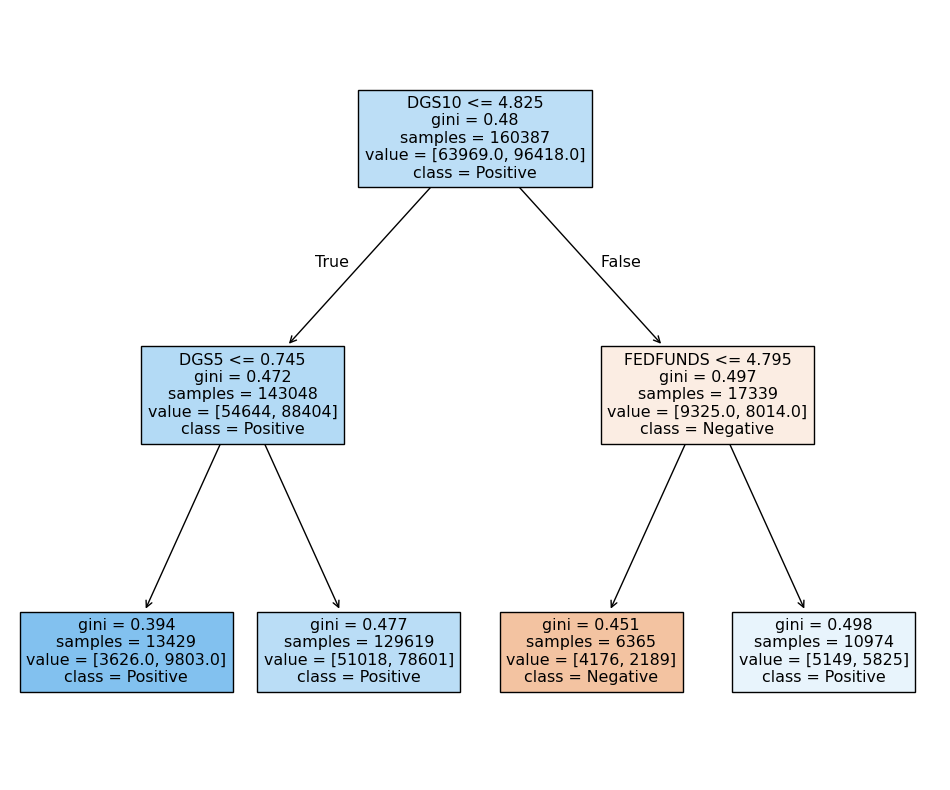

In [104]:
# Visualisation: decision tree for a few levels (max_depth variable)
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming clf_2 is your trained DecisionTreeClassifier
plt.figure(figsize=(12,10))  # Set the size of the figure
plot_tree(clf_2,
          filled=True,
          feature_names=train_columns,
          class_names=['Negative', 'Positive'],
          max_depth=2)
plt.show()

In [105]:
  tree_rules = export_text(clf_2, feature_names=list(X_train), max_depth=1)
  print(tree_rules)

|--- DGS10 <= 4.83
|   |--- DGS5 <= 0.75
|   |   |--- class: 1
|   |--- DGS5 >  0.75
|   |   |--- class: 1
|--- DGS10 >  4.83
|   |--- FEDFUNDS <= 4.80
|   |   |--- class: 0
|   |--- FEDFUNDS >  4.80
|   |   |--- class: 1



## 1.3) [Code Snippet 3] Random Forest
https://scikit-learn.org/stable/modules/ensemble.html#random-forests-and-other-randomized-tree-ensembles

In [106]:
from sklearn.ensemble import RandomForestClassifier
import time

# (12 min runtime FOR v28 machine) UNCOMMENT BELOW TO RUN HYPERPARAMs optimisation again

In [107]:
# %%time
# # hyper params tuning

# precision_matrix = {}
# best_precision = 0
# best_depth = 0
# best_estimators = 1

# for depth in [5, 7, 9, 11, 13, 15, 17, 19]:
#   for estimators in [10,50,100,200]:
#     print(f'Working with HyperParams: depth = {depth}, estimators = {estimators}')

#     # Start timing
#     start_time = time.time()
#     # fitting the tree on X_train, y_train
#     rf = RandomForestClassifier(n_estimators = estimators,
#                                 max_depth = depth,
#                                 random_state = 42,
#                                 n_jobs = -1)

#     rf = rf.fit(X_train_valid, y_train_valid)

#     # getting the predictions for TEST and accuracy score
#     y_pred_valid = rf.predict(X_valid)
#     precision_valid = precision_score(y_valid, y_pred_valid)
#     y_pred_test = rf.predict(X_test)
#     precision_test = precision_score(y_test, y_pred_test)
#     print(f'  Precision on test is {precision_test}, (precision on valid is {precision_valid} - tend to overfit)')

#     # saving to the dict
#     precision_matrix[depth, estimators] = round(precision_test,4)

#     # Measure elapsed time
#     elapsed_time = time.time() - start_time
#     print(f'Time for training: {elapsed_time:.2f} seconds, or {elapsed_time/60:.2f} minutes')

#     # updating the best precision
#     if precision_test >= best_precision:
#       best_precision = round(precision_test,4)
#       best_depth = depth
#       best_estimators = estimators
#       print(f'New best precision found for depth={depth}, estimators = {estimators}')

#     print('------------------------------')

# print(f'Matrix of precisions: {precision_matrix}')
# print(f'The best precision is {best_precision} and the best depth is {best_depth} ')

In [108]:
# uncomment when you run the hyperparam tuning again
# print(precision_matrix)

In [109]:
# pre-calculated best precision matrix (max_depth, n_estimators) for Random Forest
best_precision_matrix_random_forest = best_precision_matrix_random_forest = {
    (5, 10): 0.5498,
    (5, 50): 0.5511,
    (5, 100): 0.5511,
    (5, 200): 0.5511,
    (7, 10): 0.5540,
    (7, 50): 0.5492,
    (7, 100): 0.5495,
    (7, 200): 0.5515,
    (9, 10): 0.5411,
    (9, 50): 0.5461,
    (9, 100): 0.5507,
    (9, 200): 0.5517,
    (11, 10): 0.5623,
    (11, 50): 0.5559,
    (11, 100): 0.5565,
    (11, 200): 0.5521,
    (13, 10): 0.5510,
    (13, 50): 0.5591,
    (13, 100): 0.5614,
    (13, 200): 0.5575,
    (15, 10): 0.5596,
    (15, 50): 0.5592,
    (15, 100): 0.5585,
    (15, 200): 0.5505,
    (17, 10): 0.5538,
    (17, 50): 0.5543,
    (17, 100): 0.5510,
    (17, 200): 0.5493,
    (19, 10): 0.5611,
    (19, 50): 0.5559,
    (19, 100): 0.5599,
    (19, 200): 0.5544,
}

In [110]:
# # Define the precision_matrix from the long calculation above
# best_precision_matrix = {
#      (5, 10): 0.5498, (5, 20): 0.5506,
#      (5, 50): 0.5511, (5, 100): 0.5511,
#      (6, 10): 0.5555, (6, 20): 0.551,
#      (6, 50): 0.5498, (6, 100): 0.5509,
#      (7, 10): 0.554, (7, 20): 0.5478,
#      (7, 50): 0.5492, (7, 100): 0.5495,
#      (8, 10): 0.5475, (8, 20): 0.5425,
#      (8, 50): 0.5516, (8, 100): 0.5507}


In [111]:
# Convert data to DataFrame
df = pd.DataFrame.from_dict(best_precision_matrix_random_forest, orient='index', columns=['precision_score']).reset_index()

# Rename the columns for clarity
df.columns = ['max_depth_and_metric', 'precision_score']

# Separate the tuple into two columns
df[['max_depth', 'n_estimators']] = pd.DataFrame(df['max_depth_and_metric'].tolist(), index=df.index)

# Drop the combined column
df = df.drop(columns=['max_depth_and_metric'])

# Create line plot using Plotly Express
fig = px.line(df, x='max_depth', y='precision_score', color='n_estimators',
              labels={'max_depth': 'Max Depth', 'precision_score': 'Precision Score', 'n_estimators': 'Number of Estimators'},
              title='Random Forest Models: Precision Score vs. Max Depth for Different Number of Estimators')

# Adjust x-axis range
fig.update_xaxes(range=[5, 20])

# Show the figure
fig.show()

In [112]:
# MANUALLY SELECTED BEST - should have enough complexity and smoothness (n_estimators)
rf_best_n_estimators = 50
# MANUALLY SELECTED BEST - should have enough complexity
rf_best_max_depth = 19

In [113]:
%%time

#
# several minutes to compute (2 min)

rf_best = RandomForestClassifier(n_estimators = rf_best_n_estimators,
                                 max_depth = rf_best_max_depth,
                                 random_state = 42,
                                 n_jobs = -1)

rf_best = rf_best.fit(X_train_valid, y_train_valid)

CPU times: user 55.2 s, sys: 263 ms, total: 55.4 s
Wall time: 6.61 s


## 1.4) [Code Snippet 1] Logistic Regression
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

There can be many cases when Logistic Regression does not converge: https://forecastegy.com/posts/how-to-solve-logistic-regression-not-converging-in-scikit-learn/

In [114]:
from sklearn.linear_model import LogisticRegression

In [115]:
# Large feature magnitudes can cause convergence issues. If you haven’t already, scale your data:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_valid = scaler.fit_transform(X_train_valid)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [116]:
# UNCOMMENT TO RUN IT AGAIN

# precision_matrix = {}
# best_precision = 0
# best_C = 0
# best_iter = 0

# for c in [1, 0.1, 0.01]:
#   for iter in [50, 100, 200]:
#     print(f'Working with HyperParams: C = {c} (positive float, smaller = stronger regularization), max_iter={iter}')
#     # fitting the tree on X_train, y_train
#     # hyperParam C should be between 0 and 1
#     lr = LogisticRegression(C=c,
#                             random_state=42,
#                             max_iter=iter,
#                             solver='sag',  # 'sag' - another option
#                             n_jobs=-1)

#     lr = lr.fit(X_train_valid, y_train_valid)

#     # getting the predictions for TEST and accuracy score
#     y_pred_valid = lr.predict(X_valid)
#     precision_valid = precision_score(y_valid, y_pred_valid)
#     y_pred_test = lr.predict(X_test)
#     precision_test = precision_score(y_test, y_pred_test)
#     print(f'  Precision on test is {precision_test}, (precision on valid is {precision_valid} - tend to overfit)')
#     # saving to the dict
#     precision_matrix[(c,iter)] = round(precision_test,4)
#     # updating the best precision
#     if precision_test >= best_precision:
#       best_precision = round(precision_test,4)
#       best_C = c
#       best_iter = iter
#       print(f'New best precision found for C={c}')
#       print('------------------------------')

# print(f'Matrix of precisions: {precision_matrix}')
# print(f'The best precision is {best_precision} and the best C is {best_C}, best max_iter = {best_iter}  ')

In [117]:
# UNCOMMENT TO SEE THE RESULTS OF THE RUN
# print(precision_matrix)

In [118]:
# Params on C, iter
best_precision_matrix_logistic_regression = {(1, 50): 0.5459, (1, 100): 0.5367, (1, 200): 0.5277, (0.1, 50): 0.5466, (0.1, 100): 0.5373, (0.1, 200): 0.5285, (0.01, 50): 0.5476, (0.01, 100): 0.5428, (0.01, 200): 0.54}


In [119]:
list(best_precision_matrix_logistic_regression.items())[0]

((1, 50), 0.5459)

In [120]:
# Prepare the data
rows = []
for key, value in list(best_precision_matrix_logistic_regression.items()):
    C, max_iter = key
    combination_label = f'C={C}, max_iter={max_iter}'
    rows.append({'Combination': combination_label, 'Precision': value})

df = pd.DataFrame(rows)
df.loc[:,'Precision'] = df.Precision*100.0 # need for % visualisation

# Create the bar chart
fig = px.bar(df,
             x='Combination',
             y='Precision',
             text='Precision'
             )

# Customize the layout for better readability
fig.update_layout(
    xaxis_title='Hyperparams combinations of <C, Max Iterations>',
    yaxis_title='Precision Score',
    xaxis_tickangle=-45,
    title={
        'text': 'Precision Scores for Various Logistic Regression Hyperparameter Combinations',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)


# Update the text position
fig.update_traces(texttemplate='%{text:.2f}%',
                  textposition='inside',
                  textfont_color='white')

# Show the figure
fig.show()

## 1.5) [Code Snippet 4 - ADVANCED] Neural Network (NN) and HyperParams tuning
* [Tutorial from Tensorflow.org](https://www.tensorflow.org/tutorials/keras/classification)
* [TowardsDataScience Hyperparameter Optimization with Keras](https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53)
* [Machine Learning Mastery tutorial with Keras Deep Learning](https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/)

In [121]:
# https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53


# Extended params set

# p = {'lr': [0.01, 0.03,0.1, 0.3,1,3,10],
#      'first_neuron': [0,16,32,64,128,256],
#      'second_neuron':[0,16,32,64,128,256],
#      'first_dropout':[0,0.2,0.3],
#      'second_dropout':[0,0.2,0.3],
#      'activation_first':['relu','sigmoid','linear'],
#      'activation_second':['relu','sigmoid','linear'],
#     #  'activation_first':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
#     #  'activation_second':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
#     #  'batch_size':(2,30,10),
#     #  'loss': ('mse','mae'),
#     #  'epochs':[150],
#     #  'shape': ['brick','long_funnel'],
#      'optimizer':['adam', 'nadam', 'rmaprop','sgd'],
#     #  'losses': [logcosh, binary_crossentropy],
#     #  'last_activation':[sigmoid]
#      }


# Reduced params set and available options
p = {'lr': [0.1],
     'first_neuron': [12,24,32,48,96, 128, 196, 256],
     'second_neuron':[12,24,32,48,96, 128, 196, 256],
     'first_dropout':[0.1],
     'second_dropout':[0.1],
     'activation_first':['relu','sigmoid','softplus','tanh'],
     'activation_second':['relu'],
    #  'activation_first':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
    #  'activation_second':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
    #  'batch_size':(2,30,10),
    #  'loss': ('mse','mae'),
    #  'epochs':[150],
    #  'shape': ['brick','long_funnel'],
     'optimizer':['adam','nadam','sgd','rmaprop'],
    #  'losses': [logcosh, binary_crossentropy],
    #  'last_activation':[sigmoid]
     }


# Number of models to run and write to SHEETS:
count_models=0

nn_params = {}

for lr in p['lr']:
  for first_neuron in p['first_neuron']:
    for second_neuron in p['second_neuron']:
      for first_dropout in p['first_dropout']:
        for second_dropout in p['second_dropout']:
          for activation_first in p['activation_first']:
            for activation_second in p['activation_second']:
              for optimizer in p['optimizer']:
                # print(lr,first_neuron,second_neuron,first_dropout,second_dropout,activation_first,activation_second,optimizer,sep='/')
                count_models=count_models+1
                nn_params['learning_rate'] = lr
                nn_params['first_layer_neurons'] = first_neuron
                nn_params['first_layer_dropout'] = first_dropout
                nn_params['second_layer_neurons'] = second_neuron
                nn_params['second_layer_dropout'] = second_dropout
                nn_params['activation_first_layer'] = activation_first
                nn_params['activation_second_layer'] = activation_second
                nn_params['optimizer'] = optimizer
                # features count as an input shape
                nn_params['input_shape'] = len(X_train.keys())

# Current set of models to try
print(count_models)

1024


In [122]:
nn_params

{'learning_rate': 0.1,
 'first_layer_neurons': 256,
 'first_layer_dropout': 0.1,
 'second_layer_neurons': 256,
 'second_layer_dropout': 0.1,
 'activation_first_layer': 'tanh',
 'activation_second_layer': 'relu',
 'optimizer': 'rmaprop',
 'input_shape': 208}

In [123]:
# you need to install TF if using a v28 machine
# !pip install tensorflow

In [124]:
# UNCOMMENT TO RUN IT
# # returns best_model (trained) and best_history (history of train operations)
# best_model, best_history = train_neural_network_with_hyperparams(HYPER_PARAMS_SPACE=p,
#                                                                  MAX_MODELS=2, #not more than 2 models
#                                                                  MAX_EPOCHS=250,
#                                                                  EARLY_STOPPING_PATIENCE=10
#                                                                  )

In [125]:
# UNCOMMENT WHEN RUN AGAIN

# best_history_nn = best_history
# best_model_nn = best_model

In [126]:
# best_model_nn.summary()

In [127]:
# check the best history of training
# best_history

In [128]:
# pre computed history
best_history_nn ={'accuracy': [0.6206425428390503,
  0.6563935875892639,
  0.6715070605278015,
  0.6781659126281738,
  0.6846689581871033,
  0.6899000406265259,
  0.6924314498901367,
  0.6940774321556091,
  0.6963594555854797,
  0.6981488466262817,
  0.6982797980308533,
  0.7005742192268372],
 'loss': [0.6485477089881897,
  0.6164013743400574,
  0.6015466451644897,
  0.5939826965332031,
  0.5864177346229553,
  0.5822728872299194,
  0.5788451433181763,
  0.5766140818595886,
  0.5728825926780701,
  0.5714946389198303,
  0.5709761381149292,
  0.5681091547012329],
 'precision_1': [0.6281318068504333,
  0.6705082058906555,
  0.6927300691604614,
  0.7030346393585205,
  0.7096523642539978,
  0.7157368659973145,
  0.7195449471473694,
  0.7237764596939087,
  0.724949061870575,
  0.7277039289474487,
  0.7285037040710449,
  0.7305046916007996],
 'val_accuracy': [0.5095517039299011,
  0.5176388025283813,
  0.5059220790863037,
  0.49360036849975586,
  0.4926133453845978,
  0.4922631084918976,
  0.49605196714401245,
  0.48605450987815857,
  0.48605450987815857,
  0.4821383059024811,
  0.47784003615379333,
  0.4782857894897461],
 'val_loss': [0.7736297845840454,
  0.9822676181793213,
  1.0234887599945068,
  1.1025390625,
  1.1842303276062012,
  1.1674247980117798,
  1.1660196781158447,
  1.2397290468215942,
  1.2409558296203613,
  1.2863727807998657,
  1.3408353328704834,
  1.328245759010315],
 'val_precision_1': [0.5571497082710266,
  0.5591427087783813,
  0.5572323799133301,
  0.5471343398094177,
  0.5460649728775024,
  0.546144962310791,
  0.5497111082077026,
  0.5439006090164185,
  0.5426294207572937,
  0.5389731526374817,
  0.5362157225608826,
  0.5376880168914795]}

In [129]:
X_train_valid.shape

(160387, 208)

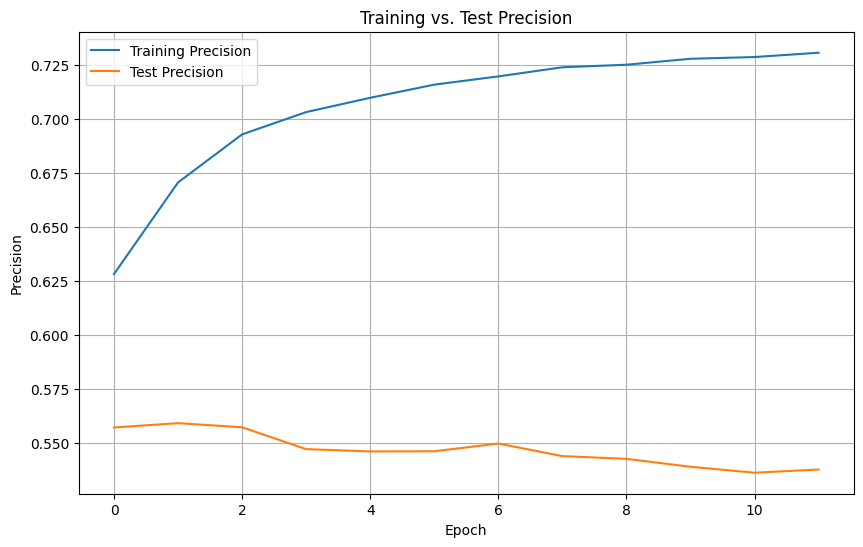

In [130]:
# Learning visualisation for the Deep Neural Network (DNN)
# The model is not actually training, as the precision and accuracy score are not improving on TRAIN/TEST with more Epochs

# Plotting accuracy
plt.figure(figsize=(10, 6))
plt.plot(best_history_nn['precision_1'], label='Training Precision')
plt.plot(best_history_nn['val_precision_1'], label='Test Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training vs. Test Precision')
plt.legend()
plt.grid(True)
plt.show()

# 2) [Code Snippet 5] Different Decision rules to improve the Precision (varying Threshold)
* best model1 **(clf_best)**: Decision Tree (max_depth=15)
* best model2 **(rf_best)**: Random Forest (n_estimators=200, max_depth=17)

## 2.1. Predicting probabilities (predict_proba), getting the distribution for probabilities, and new decision rules

In [131]:
# predicting probability instead of a label
y_pred_test = clf_best.predict_proba(X_test)

# y_pred_test = rf_best.predict_proba(X_test)

y_pred_test_class1 = [k[1] for k in y_pred_test] # k[1] is the second element in the list of Class predictions

/Users/iuliia/projects/market_zoomcamp/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



In [132]:
# example prediction
y_pred_test

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], shape=(31408, 2))

In [133]:
y_pred_test_class1_df = pd.DataFrame(y_pred_test_class1, columns=['Class1_probability'])

# sample of predictions
y_pred_test_class1_df.sample(10)

,Class1_probability
7443,0.0
2956,0.0
20779,0.0
22629,0.0
26894,1.0
23412,1.0
3656,1.0
2028,0.0
21671,0.0
5319,1.0


In [134]:
# Mean prediction is 0.3, median is 0.0, 75% quantile is 0.9
y_pred_test_class1_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Class1_probability,31408.0,0.410591,0.475831,0.0,0.0,0.0,1.0,1.0


In [135]:
# Unconditional probability of a positive growth is 55.5%
y_test.sum()/y_test.count()

np.float64(0.5510697911360163)

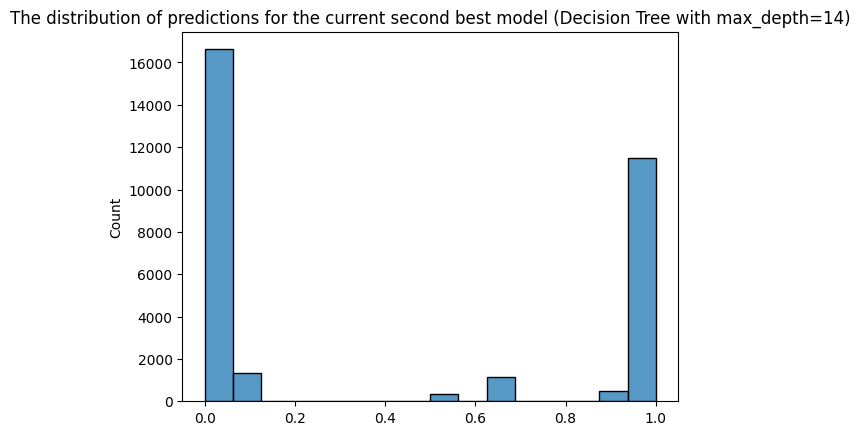

In [136]:
sns.histplot(y_pred_test_class1)

# Add a title
plt.title(f'The distribution of predictions for the current second best model (Decision Tree with max_depth={clf_best.get_depth()})')

# Show the plot
plt.show()

In [137]:
# tpr (True Positive Rate) vs. fpr (False Positive Rate) dataframe
# tp = True Positive
# tn = True Negative
# fp = False Positive
# fn = False Negative
# Decision Rule :  "y_pred>= Threshold" for Class "1"

# when only_even=True --> we'll have a step ==0.02 and leave only even records

def tpr_fpr_dataframe(y_true, y_pred, only_even=False):
    scores = []

    if only_even==False:
      thresholds = np.linspace(0, 1, 101) #[0, 0.01, 0.02, ...0.99,1.0]
    else:
      thresholds = np.linspace(0, 1, 51) #[0, 0.02, 0.04,  ...0.98,1.0]

    for t in thresholds:

        actual_positive = (y_true == 1)
        actual_negative = (y_true == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        if tp + fp > 0:
          precision = tp / (tp + fp)

        if tp + fn > 0:
          recall = tp / (tp + fn)

        if precision+recall > 0:
          f1_score = 2*precision*recall / (precision+recall)

        accuracy = (tp+tn) / (tp+tn+fp+fn)

        scores.append((t, tp, fp, fn, tn, precision, recall, accuracy, f1_score))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn','precision','recall', 'accuracy','f1_score']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores


In [138]:
df_scores = tpr_fpr_dataframe(y_test,
                              y_pred_test_class1,
                              only_even=True)

In [139]:
# full df_scores
df_scores

,threshold,tp,fp,fn,tn,precision,recall,accuracy,f1_score,tpr,fpr
0,0.00,17308,14100,0,0,0.551070,1.000000,0.551070,0.710567,1.000000,1.000000
1,0.02,7778,7008,9530,7092,0.526038,0.449388,0.473446,0.484701,0.449388,0.497021
2,0.04,7778,7008,9530,7092,0.526038,0.449388,0.473446,0.484701,0.449388,0.497021
3,0.06,7778,7008,9530,7092,0.526038,0.449388,0.473446,0.484701,0.449388,0.497021
4,0.08,7185,6313,10123,7787,0.532301,0.415126,0.476694,0.466468,0.415126,0.447730
5,0.10,7128,6309,10180,7791,0.530476,0.411833,0.475006,0.463685,0.411833,0.447447
6,0.12,7128,6309,10180,7791,0.530476,0.411833,0.475006,0.463685,0.411833,0.447447
7,0.14,7128,6309,10180,7791,0.530476,0.411833,0.475006,0.463685,0.411833,0.447447
8,0.16,7128,6309,10180,7791,0.530476,0.411833,0.475006,0.463685,0.411833,0.447447
9,0.18,7128,6309,10180,7791,0.530476,0.411833,0.475006,0.463685,0.411833,0.447447


In [140]:
df_scores[(df_scores.threshold>=0.6) & (df_scores.threshold<=0.92)]

,threshold,tp,fp,fn,tn,precision,recall,accuracy,f1_score,tpr,fpr
30,0.60,6901,6188,10407,7912,0.527237,0.398717,0.471631,0.454058,0.398717,0.438865
31,0.62,6901,6188,10407,7912,0.527237,0.398717,0.471631,0.454058,0.398717,0.438865
32,0.64,6901,6188,10407,7912,0.527237,0.398717,0.471631,0.454058,0.398717,0.438865
33,0.66,6360,5596,10948,8504,0.531950,0.367460,0.473255,0.434664,0.367460,0.396879
34,0.68,6360,5596,10948,8504,0.531950,0.367460,0.473255,0.434664,0.367460,0.396879
35,0.70,6360,5596,10948,8504,0.531950,0.367460,0.473255,0.434664,0.367460,0.396879
36,0.72,6360,5596,10948,8504,0.531950,0.367460,0.473255,0.434664,0.367460,0.396879
37,0.74,6360,5596,10948,8504,0.531950,0.367460,0.473255,0.434664,0.367460,0.396879
38,0.76,6360,5596,10948,8504,0.531950,0.367460,0.473255,0.434664,0.367460,0.396879
39,0.78,6360,5596,10948,8504,0.531950,0.367460,0.473255,0.434664,0.367460,0.396879


In [141]:
# TODO: HA to build a similar dataframe for random_forest and find optimal thresholds

<Axes: title={'center': 'Precision vs. Recall for the Best Model (Decision Tree with max_depth=15)'}, xlabel='threshold'>

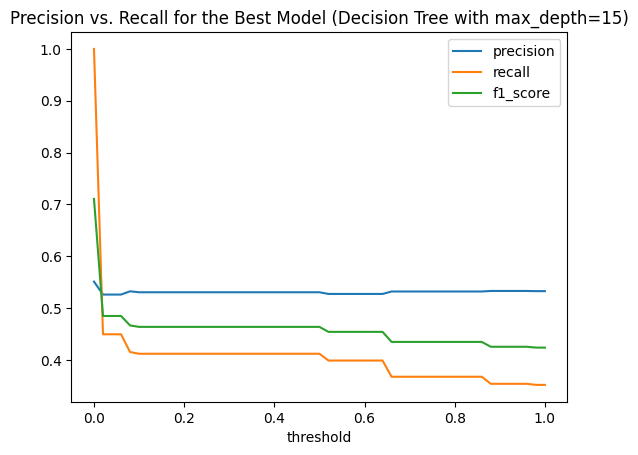

In [142]:
# Try to find high Precision score points

df_scores.plot.line(x='threshold',
                    y=['precision','recall', 'f1_score'],
                    title = 'Precision vs. Recall for the Best Model (Decision Tree with max_depth=15)')

## 2.2) [Code Snippet 6] Defining new columns with Predictions in new_df: pred7..pred10
* pred7 and pred8 are 2 decision rules for the Decision Tree (best model with max_depth=15)
* pred9 and pred10 are 2 decision rules for the Random Forest (second best model)

In [143]:
# existing predictions
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_dgs10_5',
 'pred4_manual_dgs10_fedfunds',
 'pred5_clf_10',
 'pred6_clf_5',
 'pred7_clf_second_best']

In [144]:
# adding Decision Tree predictors (clf_best) to the dataset for 2 new rules: Threshold = 0.66 and 0.78


y_pred_all = clf_best.predict_proba(X_all)
y_pred_all_class1 = [k[1] for k in y_pred_all] #list of predictions for class "1"
y_pred_all_class1_array = np.array(y_pred_all_class1) # (Numpy Array) np.array of predictions for class "1" , converted from a list

# defining a new prediction vector is easy now, as the dimensions will match
new_df['proba_pred8'] = y_pred_all_class1_array
new_df['pred8_clf_second_best_rule_84'] = (y_pred_all_class1_array >= 0.84).astype(int)

new_df['proba_pred9'] = y_pred_all_class1_array
new_df['pred9_clf_second_best_rule_92'] = (y_pred_all_class1_array >= 0.92).astype(int)

In [145]:
# adding Random Forest predictors (rf_best)
rf_best

,n_estimators,50
,criterion,'gini'
,max_depth,19
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [146]:
# make predictions of probabilities using the Random Forest model (rf_best)

y_pred_all = rf_best.predict_proba(X_all)
y_pred_all_class1 = [k[1] for k in y_pred_all] #list of predictions for class "1"
y_pred_all_class1_array = np.array(y_pred_all_class1) # (Numpy Array) np.array of predictions for class "1" , converted from a list


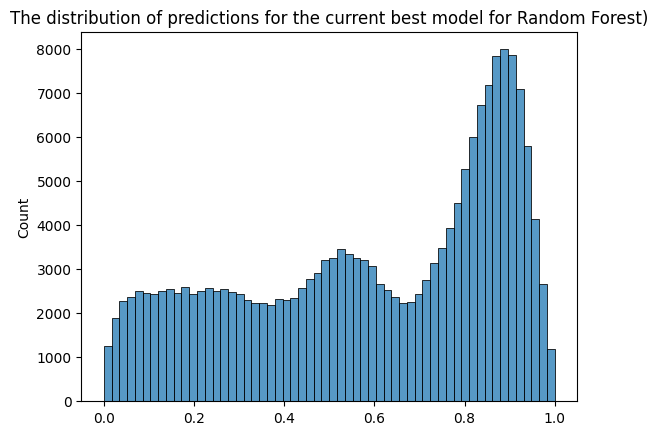

In [147]:
# PREDICTIONS ON A FULL DATASET - more smooth dataset - good sign
sns.histplot(y_pred_all_class1)

# Add a title
plt.title('The distribution of predictions for the current best model for Random Forest)')

# Show the plot
plt.show()

In [148]:
# adding Random Forest predictors (rf_best) to the dataset for 2 new rules: Threshold = 0.60 and 0.70
# defining a new prediction vector is easy now, as the dimensions will match
new_df['proba_pred10'] = y_pred_all_class1_array
new_df['pred10_rf_best_rule_55'] = (y_pred_all_class1_array >= 0.55).astype(int)

new_df['proba_pred11'] = y_pred_all_class1_array
new_df['pred11_rf_best_rule_65'] = (y_pred_all_class1_array >= 0.65).astype(int)

<Axes: >

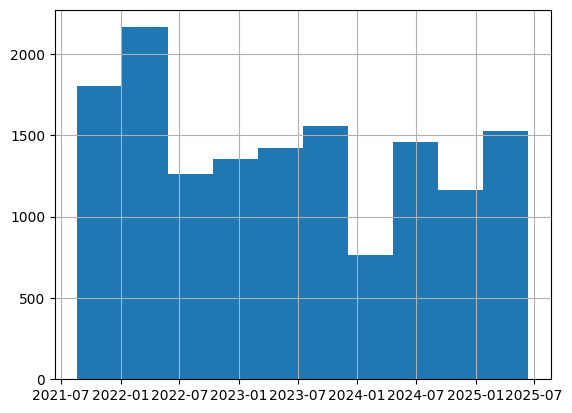

In [149]:
# Many positive predictions
new_df[(new_df.split=='test')&(new_df.pred10_rf_best_rule_55==1)].Date.hist()

<Axes: >

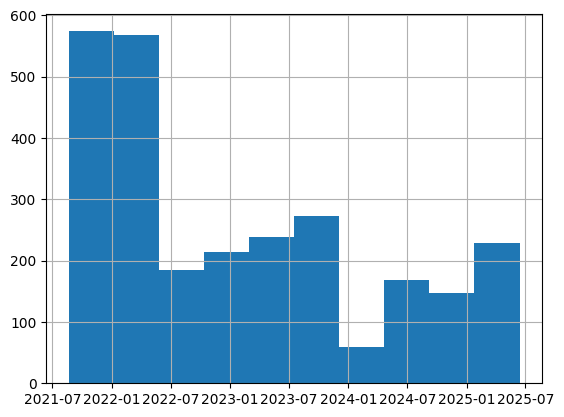

In [150]:
# When did it predict to trade for the "rare" positive prediction pred10?
new_df[(new_df.split=='test')&(new_df.pred11_rf_best_rule_65==1)].Date.hist()

In [151]:
# sample of rare predictions with high threshold
new_df[(new_df.split=='test')&(new_df.pred11_rf_best_rule_65==1)].sort_values(by='Date').sample(10)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,is_correct_pred6,is_correct_pred7,proba_pred8,pred8_clf_second_best_rule_84,proba_pred9,pred9_clf_second_best_rule_92,proba_pred10,pred10_rf_best_rule_55,proba_pred11,pred11_rf_best_rule_65
362,600.905315,603.927168,594.663441,596.694519,536471.0,0.0,0.0,LICI.NS,2023,October,...,1,1,0.979630,1,0.979630,1,0.675855,1,0.675855,1
5681,20.429757,20.594513,20.274153,20.548748,7134600.0,0.0,0.0,INFY,2021,October,...,0,1,0.917874,1,0.917874,0,0.705489,1,0.705489,1
6479,2590.247092,2618.240725,2575.893703,2589.154053,1078052.0,0.0,0.0,HINDUNILVR.NS,2021,September,...,1,0,0.685039,0,0.685039,0,0.731155,1,0.731155,1
4809,128.675144,130.941670,128.615501,130.683212,18764200.0,0.0,0.0,GOOG,2023,September,...,1,1,1.000000,1,1.000000,1,0.651502,1,0.651502,1
2650,109.026160,110.419594,108.030851,108.946533,23899200.0,0.0,0.0,META,2022,November,...,1,1,0.859296,1,0.859296,0,0.684962,1,0.684962,1
6553,18.370001,18.480000,18.110001,18.170000,7866100.0,0.0,0.0,INFY,2025,March,...,0,1,1.000000,1,1.000000,1,0.703529,1,0.703529,1
3534,85.063661,85.194162,82.869400,83.347603,17079000.0,0.0,0.0,AVGO,2023,August,...,0,0,0.957780,1,0.957780,1,0.665855,1,0.665855,1
6491,2515.866979,2544.383465,2490.439779,2518.528564,2158809.0,0.0,0.0,HINDUNILVR.NS,2021,October,...,1,0,0.685039,0,0.685039,0,0.660307,1,0.660307,1
5516,18.719920,18.837226,18.074743,18.084518,20878300.0,0.0,0.0,IBN,2022,March,...,0,1,0.917874,1,0.917874,0,0.718133,1,0.718133,1
9060,277.303647,283.667044,276.817149,279.950195,41736100.0,0.0,0.0,MSFT,2022,February,...,0,0,0.141026,0,0.141026,0,0.674222,1,0.674222,1


In [152]:
# List of ALL current predictions
PREDICTIONS = [k for k in new_df.keys() if k.startswith('pred')]
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_dgs10_5',
 'pred4_manual_dgs10_fedfunds',
 'pred5_clf_10',
 'pred6_clf_5',
 'pred7_clf_second_best',
 'pred8_clf_second_best_rule_84',
 'pred9_clf_second_best_rule_92',
 'pred10_rf_best_rule_55',
 'pred11_rf_best_rule_65']

In [153]:
# Pred 10: How many positive prediction per day (out of 33 stocks possible)
pred10_daily_positive_count = pd.DataFrame(new_df[(new_df.split=='test')&(new_df.pred11_rf_best_rule_65==1)].groupby('Date')['pred11_rf_best_rule_65'].count())

In [154]:
# Pred 9: How many positive prediction per day (out of 33 stocks possible)
pred9_daily_positive_count = pd.DataFrame(new_df[(new_df.split=='test')&(new_df.pred10_rf_best_rule_55==1)].groupby('Date')['pred10_rf_best_rule_55'].count())

In [155]:
# Unique trading days on Test (4 years)
new_df[(new_df.split=='test')].Date.nunique()

991

In [156]:
pred10_daily_positive_count

,pred11_rf_best_rule_65
Date,
2021-08-20,5
2021-08-23,12
2021-08-24,9
2021-08-25,12
2021-08-26,9
...,...
2025-06-09,11
2025-06-10,10
2025-06-11,7


array([[<Axes: title={'center': 'pred11_rf_best_rule_65'}>]], dtype=object)

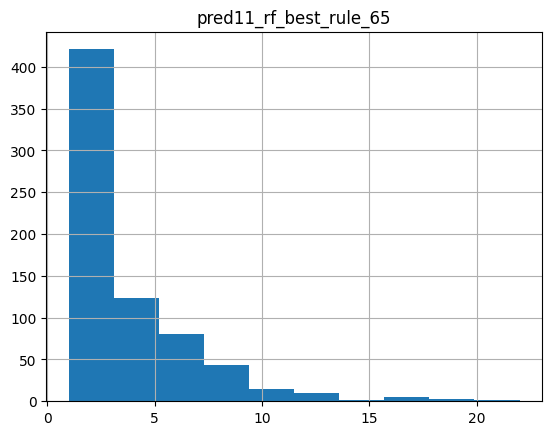

In [157]:
pred10_daily_positive_count.hist()

In [158]:
# 75% cases we have not more than 6 bets of $100
pred10_daily_positive_count.describe().T

,count,mean,std,min,25%,50%,75%,max
pred11_rf_best_rule_65,705.0,3.767376,3.224958,1.0,1.0,3.0,5.0,22.0


array([[<Axes: title={'center': 'pred10_rf_best_rule_55'}>]], dtype=object)

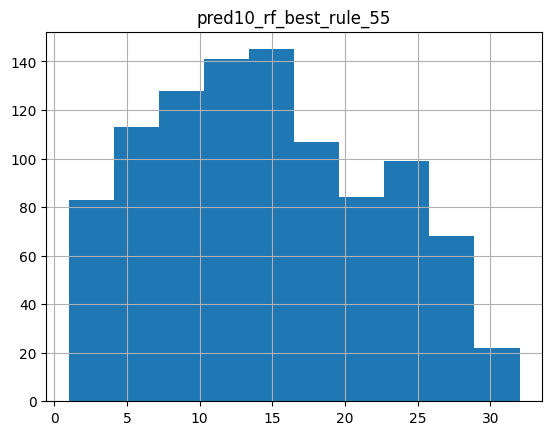

In [159]:
pred9_daily_positive_count.hist()

In [160]:
pred9_daily_positive_count.describe().T

,count,mean,std,min,25%,50%,75%,max
pred10_rf_best_rule_55,990.0,14.627273,7.340034,1.0,9.0,14.0,20.0,32.0


## 2.3) Agg. stats on ALL predictions

In [161]:
# let's review the Predictions:
PREDICTIONS, IS_CORRECT = get_predictions_correctness(new_df, to_predict='is_positive_growth_30d_future')


Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_dgs10_5', 'pred4_manual_dgs10_fedfunds', 'pred5_clf_10', 'pred6_clf_5', 'pred7_clf_second_best', 'pred8_clf_second_best_rule_84', 'pred9_clf_second_best_rule_92', 'pred10_rf_best_rule_55', 'pred11_rf_best_rule_65']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5', 'is_correct_pred6', 'is_correct_pred7', 'is_correct_pred8', 'is_correct_pred9', 'is_correct_pred10', 'is_correct_pred11']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    443
0    351
Name: count, dtype: int64
is_correct_pred0
1    0.557935
0    0.442065
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    9748
0    8243
Name: count, dtype: i

In [162]:
# check approx. periods : Train is 2000-01...2017-01, Valid is 2017-01..2020-09, Test is 2020-09..2024-05
new_df.groupby('split').Date.agg(['min','max'])

,min,max
split,,
test,2021-08-20,2025-06-13
train,2000-01-03,2017-10-25
validation,2017-10-26,2021-08-19


In [163]:
# GET PREDICTION NUMBER: Easier solution not using regular expressions

# Example string
example_string = "pred10_rf_best_rule_60"

# Split the string by '_'
parts = example_string.split('_')

# Extract the part with 'pred' and remove the 'pred' prefix
pred_number = parts[0].replace('pred', '')

# Print the result
print(pred_number)

# Print in one line
print(int(example_string.split('_')[0].replace('pred', '')))


10
10


In [164]:
# all predictions
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_dgs10_5',
 'pred4_manual_dgs10_fedfunds',
 'pred5_clf_10',
 'pred6_clf_5',
 'pred7_clf_second_best',
 'pred8_clf_second_best_rule_84',
 'pred9_clf_second_best_rule_92',
 'pred10_rf_best_rule_55',
 'pred11_rf_best_rule_65']

In [165]:
# all predictions on MODELS (not-manual predictions)
PREDICTIONS_ON_MODELS = [p for p in PREDICTIONS if int(p.split('_')[0].replace('pred', ''))>=5]
PREDICTIONS_ON_MODELS

['pred5_clf_10',
 'pred6_clf_5',
 'pred7_clf_second_best',
 'pred8_clf_second_best_rule_84',
 'pred9_clf_second_best_rule_92',
 'pred10_rf_best_rule_55',
 'pred11_rf_best_rule_65']

In [166]:
# all predictions on Models - correctness
IS_CORRECT_ON_MODELS = [p for p in IS_CORRECT if int(p.replace('is_correct_pred', ''))>=5]
IS_CORRECT_ON_MODELS

['is_correct_pred5',
 'is_correct_pred6',
 'is_correct_pred7',
 'is_correct_pred8',
 'is_correct_pred9',
 'is_correct_pred10',
 'is_correct_pred11']

In [167]:
# predictions on models
# pred10_rf_best_rule_60: ONLY 2% of TEST cases predicted with high confidence of growth
new_df.groupby('split')[PREDICTIONS_ON_MODELS].agg(['count','sum','mean']).T

split                                        test          train    validation
pred5_clf_10                  count  31408.000000  129730.000000  30657.000000
                              sum    19326.000000   99979.000000  23780.000000
                              mean       0.615321       0.770670      0.775679
pred6_clf_5                   count  31408.000000  129730.000000  30657.000000
                              sum    18453.000000  104367.000000  22899.000000
                              mean       0.587525       0.804494      0.746942
pred7_clf_second_best         count  31408.000000  129730.000000  30657.000000
                              sum    18911.000000   90497.000000  22587.000000
                              mean       0.602108       0.697580      0.736765
pred8_clf_second_best_rule_84 count  31408.000000  129730.000000  30657.000000
                              sum    15681.000000   33363.000000  11688.000000
                              mean       0.499268       0.257173      0.381251
pred9_clf_second_best_rule_92 count  31408.000000  129730.000000  30657.000000
                              sum    11906.000000   20746.000000   6905.000000
                              mean       0.379075       0.159917      0.225234
pred10_rf_best_rule_55        count  31408.000000  129730.000000  30657.000000
                              sum    14481.000000   77570.000000  19833.000000
                              mean       0.461061       0.597934      0.646932
pred11_rf_best_rule_65        count  31408.000000  129730.000000  30657.000000
                              sum     2656.000000   73296.000000  19248.000000
                              mean       0.084564       0.564989      0.627850

In [168]:
# 10 predictions stats (check TEST set)
new_df.groupby('split')[PREDICTIONS].agg(['count','sum','mean']).T

split                                        test          train    validation
pred0_manual_cci              count  31408.000000  129730.000000  30657.000000
                              sum      794.000000    3428.000000    886.000000
                              mean       0.025280       0.026424      0.028900
pred1_manual_prev_g1          count  31408.000000  129730.000000  30657.000000
                              sum    17991.000000   76372.000000  19721.000000
                              mean       0.572816       0.588700      0.643279
pred2_manual_prev_g1_and_snp  count  31408.000000  129730.000000  30657.000000
                              sum    13367.000000   57404.000000  16695.000000
                              mean       0.425592       0.442488      0.544574
pred3_manual_dgs10_5          count  31408.000000  129730.000000  30657.000000
                              sum      997.000000   13333.000000  11908.000000
                              mean       0.031744       0.102775      0.388427
pred4_manual_dgs10_fedfunds   count  31408.000000  129730.000000  30657.000000
                              sum     5660.000000   30611.000000      0.000000
                              mean       0.180209       0.235959      0.000000
pred5_clf_10                  count  31408.000000  129730.000000  30657.000000
                              sum    19326.000000   99979.000000  23780.000000
                              mean       0.615321       0.770670      0.775679
pred6_clf_5                   count  31408.000000  129730.000000  30657.000000
                              sum    18453.000000  104367.000000  22899.000000
                              mean       0.587525       0.804494      0.746942
pred7_clf_second_best         count  31408.000000  129730.000000  30657.000000
                              sum    18911.000000   90497.000000  22587.000000
                              mean       0.602108       0.697580      0.736765
pred8_clf_second_best_rule_84 count  31408.000000  129730.000000  30657.000000
                              sum    15681.000000   33363.000000  11688.000000
                              mean       0.499268       0.257173      0.381251
pred9_clf_second_best_rule_92 count  31408.000000  129730.000000  30657.000000
                              sum    11906.000000   20746.000000   6905.000000
                              mean       0.379075       0.159917      0.225234
pred10_rf_best_rule_55        count  31408.000000  129730.000000  30657.000000
                              sum    14481.000000   77570.000000  19833.000000
                              mean       0.461061       0.597934      0.646932
pred11_rf_best_rule_65        count  31408.000000  129730.000000  30657.000000
                              sum     2656.000000   73296.000000  19248.000000
                              mean       0.084564       0.564989      0.627850

# 3) Trading Simulations

* create simulation 1 features: like "sim1_pred0" ... "sim1_pred10"

## 3.1) Investing $100 on every positive prediction
* fees = 0.1% for each buy and sell operation ==> 0.2% for buy+sell operation

### [Code Snippet 7] 3.1.1 Calculate fin. result from simulations for one predictor 'pred6_clf_best'

In [169]:
# current prediction
pred = 'pred6_clf_5'

In [170]:
# Total Number of Investment Opportunities
new_df[new_df.split=='test'].Close_x.count()

np.int64(31408)

In [171]:
# Total Number of Days (~4 years of trading)
new_df[new_df.split=='test'].Date.nunique()

991

In [172]:
# check actual future growth with 'growth_future_5d', correctness of the prediction with 'is_positive_growth_5d_future'
TO_PREDICT

['growth_future_30d', 'is_positive_growth_30d_future']

In [173]:
# SAMPLE: compare the predictions from pred6_clf_best to real is_positive_growth_30d_future
new_df[['growth_future_30d','is_positive_growth_30d_future',pred]].sample(10)

,growth_future_30d,is_positive_growth_30d_future,pred6_clf_5
592,0.910041,0,1
4244,1.077168,1,1
5547,0.984970,0,0
7693,1.008109,1,0
1497,0.994679,0,0
4254,1.120012,1,1
5967,1.276002,1,1
2771,1.042553,1,1
3209,1.106975,1,0
4704,1.187877,1,1


In [174]:
# GROSS REVENUE: ONLY when current_prediction equals to 1: invest $100 into that stock (buy), and sell in 1week (sell)
new_df['sim1_gross_rev_pred6'] = new_df[pred] * 100 * (new_df['growth_future_30d']-1)

In [175]:
# FEES: 0.1% for each operation , 0.2% for buy+sell ONLY when current_prediction equals to one
new_df['sim1_fees_pred6'] = -new_df[pred] * 100 * 0.002

In [176]:
# NET REVENUE: GROSS_REVENUE + FEES
new_df['sim1_net_rev_pred6'] = new_df['sim1_gross_rev_pred6'] + new_df['sim1_fees_pred6']

In [177]:
# sample results
COLUMNS_FIN_RESULT = ['Date','Ticker','Close_x']+TO_PREDICT+ [pred,  'sim1_gross_rev_pred6','sim1_fees_pred6','sim1_net_rev_pred6']
new_df[(new_df.split=='test')&(new_df[pred]==1)][COLUMNS_FIN_RESULT].sample(10)

,Date,Ticker,Close_x,growth_future_30d,is_positive_growth_30d_future,pred6_clf_5,sim1_gross_rev_pred6,sim1_fees_pred6,sim1_net_rev_pred6
11210,2024-09-04,JPM,215.546387,1.025899,1,1,2.589925,-0.2,2.389925
6910,2023-03-01,SAP,110.969643,1.120984,1,1,12.098394,-0.2,11.898394
13209,2024-10-21,LLY,901.228088,0.899073,0,1,-10.092701,-0.2,-10.292701
5687,2024-02-29,HDB,53.500000,1.066355,1,1,6.635513,-0.2,6.435513
552,2024-08-12,LICI.NS,1074.349976,0.957044,0,1,-4.295623,-0.2,-4.495623
3697,2022-11-22,V,206.399323,1.035278,1,1,3.527786,-0.2,3.327786
5499,2023-05-31,HDB,64.400002,1.049068,1,1,4.906826,-0.2,4.706826
4639,2023-01-24,GOOG,98.623764,0.954037,0,1,-4.596314,-0.2,-4.796314
6909,2024-10-29,AMZN,190.830002,1.206624,1,1,20.662366,-0.2,20.462366
5919,2023-01-06,MC.PA,712.582764,1.092949,1,1,9.294887,-0.2,9.094887


In [178]:
# DAILY INVESTMENTS
filter_test_and_positive_pred = (new_df.split=='test')&(new_df[pred]==1)
df_investments_count_daily = pd.DataFrame(new_df[filter_test_and_positive_pred].groupby('Date')[pred].count())
sim1_avg_investments_per_day = df_investments_count_daily[pred].quantile(0.75)  # 75% case - how many $100 investments per day do we have?
print(sim1_avg_investments_per_day)

33.0


In [179]:
# how many times do we invest daily (a lot)
df_investments_count_daily.describe().T

,count,mean,std,min,25%,50%,75%,max
pred6_clf_5,585.0,31.54359,4.708841,8.0,33.0,33.0,33.0,33.0


In [180]:
new_df[(new_df.split=='test')&(new_df[pred]==1)][['sim1_gross_rev_pred6','sim1_fees_pred6','sim1_net_rev_pred6']].sum()

sim1_gross_rev_pred6    66660.624344
sim1_fees_pred6         -3690.600000
sim1_net_rev_pred6      62996.424344
dtype: float64

### 3.1.2 Calculate fin. results for all fields
* Simplified and approximate calculation

In [181]:
# Calculate fin. result for ALL predictions (manual and produced by models)

sim1_results = [] # results in Array

# Iterate over all predictions
for pred in PREDICTIONS:
  print(f'Calculating sumulation for prediction {pred}:')
  print(f"    Count times of investment {len(new_df[(new_df.split=='test')&(new_df[pred]==1)])} out of {len(new_df[(new_df.split=='test')])} TEST records")

  # Prefix: e.g. pred1 or pred10
  pred_prefix= pred.split('_')[0]

  # Fin. result columns: define new records for EACH positive prediction
  new_df['sim1_gross_rev_'+pred_prefix] = new_df[pred] * 100 * (new_df['growth_future_30d']-1)
  new_df['sim1_fees_'+pred_prefix] = -new_df[pred] * 100 * 0.002
  new_df['sim1_net_rev_'+pred_prefix] = new_df['sim1_gross_rev_'+pred_prefix] + new_df['sim1_fees_'+pred_prefix]

  # calculate agg. results for each PREDICTION columns (pred) on TEST
  filter_test_and_positive_pred = (new_df.split=='test')&(new_df[pred]==1) # filter records on TEST set, when current prediction is 1 (we invest $100 for 1 week ahead - 5 periods)
  sim1_count_investments = len(new_df[filter_test_and_positive_pred])
  sim1_gross_rev = new_df[filter_test_and_positive_pred]['sim1_gross_rev_'+pred_prefix].sum()
  sim1_fees = new_df[filter_test_and_positive_pred]['sim1_fees_'+pred_prefix].sum()
  sim1_net_rev = new_df[filter_test_and_positive_pred]['sim1_net_rev_'+pred_prefix].sum()

  if sim1_gross_rev>0:
    sim1_fees_percentage = -sim1_fees/sim1_gross_rev
  else:
    sim1_fees_percentage = None

  if sim1_count_investments>0:
    sim1_average_net_revenue = sim1_net_rev/sim1_count_investments
  else:
    sim1_average_net_revenue = None

  # APPROXIMATE CAPITAL REQUIRED and CAGR Calculation
  df_investments_count_daily = pd.DataFrame(new_df[filter_test_and_positive_pred].groupby('Date')[pred].count())
  sim1_avg_investments_per_day = df_investments_count_daily[pred].mean()
  sim1_q75_investments_per_day = df_investments_count_daily[pred].quantile(0.75)  # 75% case - how many $100 investments per day do we have?
  # df_investments_count_daily[pred].mean()
  sim1_capital = 100 * 30 * sim1_q75_investments_per_day # 30 (trading) days  in a row with positive predictions
  # CAGR: average growth per year. E.g. if you have 1.5 return (50% growth in 4 years) --> (1.5)**(1/4) = 1.106 or 10.6% average
  sim1_CAGR = ((sim1_capital+sim1_net_rev)/sim1_capital)**(1/4)

  # append to DF
  sim1_results.append((pred,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR))


  # output for all predictions with some positive predictions
  if  sim1_count_investments>1:
    print(f"    Financial Result: \n {new_df[filter_test_and_positive_pred][['sim1_gross_rev_'+pred_prefix,'sim1_fees_'+pred_prefix,'sim1_net_rev_'+pred_prefix]].sum()}")
    print(f"        Count Investments in 4 years (on TEST): {sim1_count_investments}")
    print(f"        Gross Revenue: ${int(sim1_gross_rev)}")
    print(f"        Fees (0.2% for buy+sell): ${int(-sim1_fees)}")
    print(f"        Net Revenue: ${int(sim1_net_rev)}")
    print(f"        Fees are {int(-100.0*sim1_fees/sim1_gross_rev)} % from Gross Revenue")
    print(f"        Capital Required : ${int(sim1_capital)} (Vbegin)")
    print(f"        Final value (Vbegin + Net_revenue) : ${int(sim1_capital + sim1_net_rev)} (Vfinal)")

    print(f"        Average CAGR on TEST (4 years) : {np.round(sim1_CAGR,3)}, or {np.round(100.0*(sim1_CAGR-1),1)}% ")

    print(f"        Average daily stats: ")
    print(f"            Average net revenue per investment: ${np.round(sim1_net_rev/sim1_count_investments,2)} ")
    print(f"            Average investments per day: {int(np.round(sim1_avg_investments_per_day))} ")
    print(f"            Q75 investments per day: {int(np.round(sim1_q75_investments_per_day))} ")
    print('=============================================+')


# results in a DataFrame from an Array
columns_simulation = ['prediction', 'sim1_count_investments', 'sim1_gross_rev', 'sim1_fees', 'sim1_net_rev', 'sim1_fees_percentage','sim1_average_net_revenue','sim1_avg_investments_per_day','sim1_capital','sim1_CAGR']

df_sim1_results = pd.DataFrame(sim1_results,columns=columns_simulation)

Calculating sumulation for prediction pred0_manual_cci:
    Count times of investment 794 out of 31408 TEST records
    Financial Result: 
 sim1_gross_rev_pred0    1613.043262
sim1_fees_pred0         -158.800000
sim1_net_rev_pred0      1459.643262
dtype: float64
        Count Investments in 4 years (on TEST): 794
        Gross Revenue: $1613
        Fees (0.2% for buy+sell): $158
        Net Revenue: $1459
        Fees are 9 % from Gross Revenue
        Capital Required : $6000 (Vbegin)
        Final value (Vbegin + Net_revenue) : $7459 (Vfinal)
        Average CAGR on TEST (4 years) : 1.056, or 5.6% 
        Average daily stats: 
            Average net revenue per investment: $1.84 
            Average investments per day: 2 
            Q75 investments per day: 2 
=============================================+
Calculating sumulation for prediction pred1_manual_prev_g1:
    Count times of investment 17991 out of 31408 TEST records
    Financial Result: 
 sim1_gross_rev_pred1    29618

In [182]:
df_sim1_results['sim1_growth_capital_4y'] = (df_sim1_results.sim1_net_rev+df_sim1_results.sim1_capital) / df_sim1_results.sim1_capital

In [183]:
# final comparison
df_sim1_results

,prediction,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR,sim1_growth_capital_4y
0,pred0_manual_cci,794,1613.043262,-158.8,1459.643262,0.098447,1.838342,1.850816,6000.0,1.055946,1.243274
1,pred1_manual_prev_g1,17991,29618.243475,-3598.2,26167.843475,0.121486,1.454496,18.154390,75000.0,1.077694,1.348905
2,pred2_manual_prev_g1_and_snp,13367,17019.666162,-2673.4,14475.066162,0.157077,1.082896,22.967354,81000.0,1.041960,1.178705
3,pred3_manual_dgs10_5,997,2845.843984,-199.4,2646.443984,0.070067,2.654407,31.156250,96000.0,1.006822,1.027567
4,pred4_manual_dgs10_fedfunds,5660,8594.814190,-1132.0,7660.814190,0.131707,1.353501,31.620112,99000.0,1.018808,1.077382
5,pred5_clf_10,19326,52111.465922,-3865.2,48338.465922,0.074172,2.501214,19.680244,87000.0,1.116800,1.555615
6,pred6_clf_5,18453,66660.624344,-3690.6,62996.424344,0.055364,3.413885,31.543590,99000.0,1.131013,1.636328
7,pred7_clf_second_best,18911,52744.060807,-3782.2,49042.060807,0.071709,2.593309,19.121335,81000.0,1.125640,1.605458
8,pred8_clf_second_best_rule_84,15681,48918.841799,-3136.2,45858.041799,0.064110,2.924434,15.984709,72000.0,1.131115,1.636917
9,pred9_clf_second_best_rule_92,11906,38776.961383,-2381.2,36459.561383,0.061408,3.062285,12.223819,45000.0,1.159932,1.810212


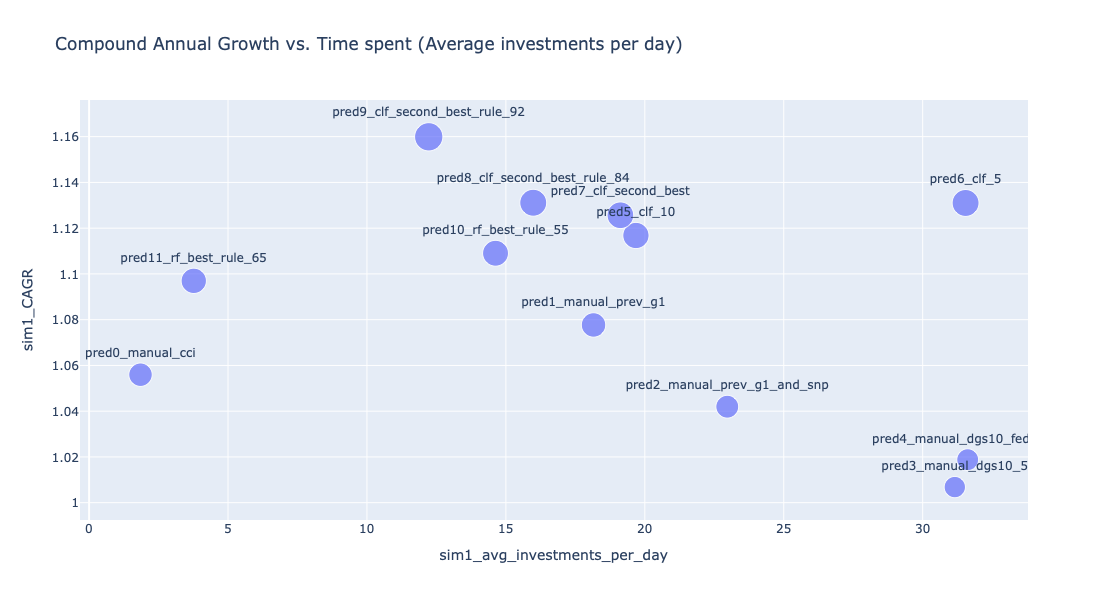

In [184]:
# Create the scatter plot
fig = px.scatter(
    df_sim1_results.dropna(),
    x='sim1_avg_investments_per_day',
    y='sim1_CAGR',
    size='sim1_growth_capital_4y',  # Use the 'size' parameter for sim1_CAGR
    text='prediction',
    title='Compound Annual Growth vs. Time spent (Average investments per day)',
    labels={'sim1_capital': 'Initial Capital Requirement', 'growth_capital_4y': '4-Year Capital Growth'},
    height=600  # <- Increase height here

)

# Update the layout to improve readability of the annotations
fig.update_traces(textposition='top center')

# Show the plot
fig.show()

In [185]:
# detailed info from the bubble chart above on the winners
# top 1 result
df_sim1_results[df_sim1_results.prediction.isin(['pred9_clf_second_best_rule_92'])]

,prediction,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR,sim1_growth_capital_4y
9,pred9_clf_second_best_rule_92,11906,38776.961383,-2381.2,36459.561383,0.061408,3.062285,12.223819,45000.0,1.159932,1.810212


In [186]:
# top 2-3 results
df_sim1_results[df_sim1_results.prediction.isin(['pred8_clf_second_best_rule_84','pred7_clf_second_best'])]

,prediction,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR,sim1_growth_capital_4y
7,pred7_clf_second_best,18911,52744.060807,-3782.2,49042.060807,0.071709,2.593309,19.121335,81000.0,1.125640,1.605458
8,pred8_clf_second_best_rule_84,15681,48918.841799,-3136.2,45858.041799,0.064110,2.924434,15.984709,72000.0,1.131115,1.636917
